In [195]:
import scipy, glob, os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.io import loadmat

In [196]:
# all files
all_files = glob.glob( 'ExampleData/*.mat')
# sort files by name
all_files.sort()

# load one example dataset
fnum = 1
file = all_files[fnum]

# load .mat file
data = loadmat(file)
data.keys()

dict_keys(['__header__', '__version__', '__globals__', 'A', '__function_workspace__'])

In [197]:
# behavior is in A struct
beh = data['A'][0,0]

# list fields in behavior
beh.dtype

dtype([('tau', 'O'), ('wait_thresh', 'O'), ('date', 'O'), ('ntrials', 'O'), ('catch', 'O'), ('prob_catch', 'O'), ('reward', 'O'), ('reward_delay', 'O'), ('block', 'O'), ('hits', 'O'), ('vios', 'O'), ('optout', 'O'), ('wait_time', 'O'), ('trial_num', 'O'), ('ITI', 'O'), ('BlockNum', 'O'), ('BlockPosition', 'O')])

In [198]:
# create a pandas dataframe from the behavior struct
fieldnames = ['catch', 'reward', 'reward_delay', 'block', 'hits', 'vios', 'optout', 'wait_time', 'trial_num', 'ITI', 'BlockNum', 'BlockPosition']
beh_df = pd.DataFrame({field: beh[field].flatten() for field in fieldnames})
# show the first few rows of the dataframe
beh_df

catch  reward  reward_delay  block  hits  vios  optout  wait_time  \
0         0      20      2.887500      1     0     1       0        NaN   
1         0      20      0.841210      1     1     0       0     0.8412   
2         0      80      2.521668      1     1     0       0     2.5217   
3         0      40      0.331504      1     1     0       0     0.3315   
4         0      20      2.067045      1     0     1       0        NaN   
...     ...     ...           ...    ...   ...   ...     ...        ...   
5969      0       5      0.222886      1     1     0       0     0.2229   
5970      1      20    100.000000      1     0     1       0        NaN   
5971      0      20      2.412661      1     1     0       0     2.4127   
5972      0      20      9.492731      3     1     0       0     9.4927   
5973      0      20      0.168076      3     0     1       0        NaN   

      trial_num       ITI  BlockNum  BlockPosition  
0             1  130.0760         1              1  
1             2    0.1897         2              2  
2             3    0.6950         3              3  
3             4    0.8013         4              4  
4             5    1.0470         5              5  
...         ...       ...       ...            ...  
5969        415    1.7404        66             -3  
5970        416    1.1156        67             -2  
5971        417    1.1481        68             -1  
5972        418    3.2551         1              1  
5973        419    3.4444         2             -1  

[5974 rows x 12 columns]

Number of sessions: 15


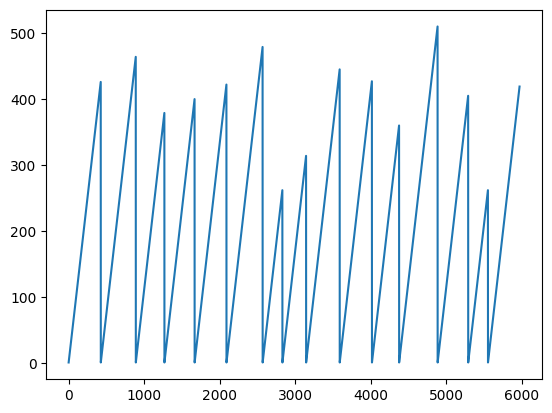

In [199]:
# how many session in this file? trial num goes from 1 to max then resets at each new session
plt.plot( beh_df['trial_num'])
restarts = np.where(beh_df['trial_num']==1)[0]
num_sessions = len(restarts)
print( f'Number of sessions: {num_sessions}')

15

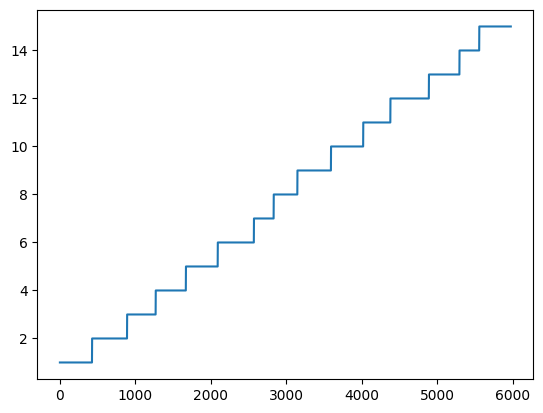

In [200]:
# add a column for session number
beh_df['session_num'] = 0
for i in range(num_sessions):
    start = restarts[i]
    end = restarts[i+1] if (i < num_sessions - 1) else len(beh_df) # end of session is one less than next restart; last session goes to end of dataframe (since no next restart )
    beh_df.loc[start:end-1, 'session_num'] = i + 1
plt.plot( beh_df['session_num'])
max( beh_df['session_num'] )


In [201]:
# type of trial:
# hits == 1 ==> hit (animal gets reward)
# hits == 0 ==> miss (animal does not get reward)

# vios == 1 ==> violation (animal does not get reward); do not count as a hit or miss
# catch == 1 ==> catch trial (no reward will be given on this trial), use wait times only on these catch trials (wait from reward offer to animal opting out)

# optout == 1 ==> animal went to the optout port
# optout == 0 ==> animal did not go to the optout port


In [202]:
# only use hit trials to calculate reward consumed
# mean reward across all sessions
print( 'mean reward: ', beh_df['reward'][beh_df['hits']==1].mean() )

# mean reward on each session
print( 'mean reward by session: ' )
print(beh_df['reward'][beh_df['hits']==1].groupby(beh_df['session_num']).mean()    )

mean reward:  32.27790014684288
mean reward by session: 
session_num
1     28.423645
2     30.316206
3     35.138889
4     37.549505
5     29.953271
6     28.256410
7     29.797980
8     32.103659
9     33.675000
10    34.497207
11    31.676471
12    27.775000
13    36.281250
14    34.904762
15    35.600000
Name: reward, dtype: float64


In [203]:
# wait time on catch trials
print( 'mean wait time: ', beh_df['wait_time'][beh_df['catch']==1].mean() )
# wait time on each session
print( 'mean wait time by session: ', beh_df['wait_time'][beh_df['catch']==1].groupby(beh_df['session_num']).mean()   )

mean wait time:  11.151664901477833
mean wait time by session:  session_num
1     10.538401
2     10.921872
3     10.358323
4     10.608250
5     11.380526
6     11.380540
7     11.648105
8     11.643573
9     11.541877
10    10.671123
11    12.469205
12    11.219567
13    11.585254
14    12.274072
15    10.188992
Name: wait_time, dtype: float64


# wait times as a function of reward and block

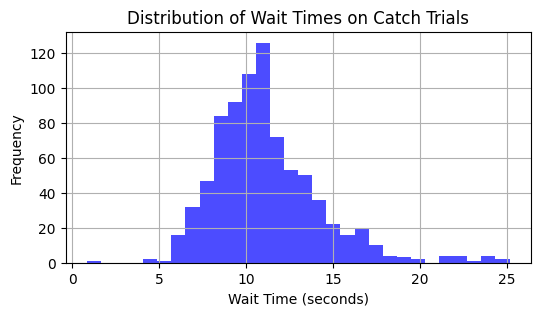

In [204]:
# visualize distribution of wait times
plt.figure(figsize=(6, 3))
plt.hist(beh_df['wait_time'][beh_df['catch']==1], bins=30, color='blue', alpha=0.7)
plt.title('Distribution of Wait Times on Catch Trials')
plt.xlabel('Wait Time (seconds)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

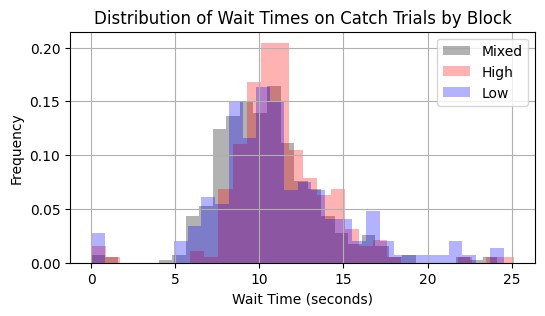

In [205]:
# histogram of wait time by block
plt.figure(figsize=(6, 3))
# blocks: 1=mixed, 2=high, 3=low
block_labels = {1: 'Mixed', 2: 'High', 3: 'Low'}
block_colors = {1: 'black', 2: 'red', 3: 'blue'}

for block in [1, 2, 3]:
    plt.hist(beh_df['wait_time'][(beh_df['optout']==1) & (beh_df['block']==block)], bins=30, alpha=0.3, label=block_labels[block], density=True, color=block_colors[block])
plt.title('Distribution of Wait Times on Catch Trials by Block')
plt.xlabel('Wait Time (seconds)')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.show()

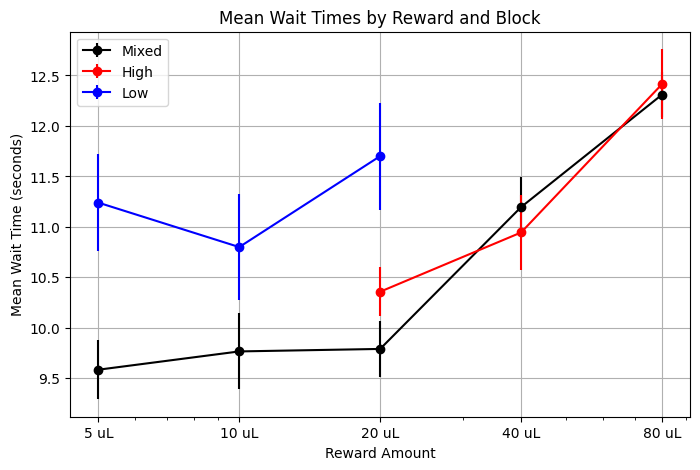

In [206]:
# wait times per reward per block
# only use optout trials

unique_blocks = np.sort(beh_df['block'].unique())
unique_rewards = np.sort(beh_df['reward'].unique())

block_labels = {1: 'Mixed', 2: 'High', 3: 'Low'}
block_colors = {1: 'black', 2: 'red', 3: 'blue'}


# create a matrix to hold mean wait times for each block and reward combination
wait_times = np.zeros((len(unique_blocks), len(unique_rewards)))
# save the standard error of wait times
wait_times_std = np.zeros((len(unique_blocks), len(unique_rewards)))

for i, block in enumerate(unique_blocks):
    for j, reward in enumerate(unique_rewards):        
        wait_times[i, j] = beh_df['wait_time'][(beh_df['optout']==1) & (beh_df['block']==block) & (beh_df['reward']==reward)].mean() # only use optout trials, match for block and reward
        wait_times_std[i, j] = beh_df['wait_time'][(beh_df['optout']==1) & (beh_df['block']==block) & (beh_df['reward']==reward)].sem()

# plotting the wait times
plt.figure(figsize=(8, 5))
for i, block in enumerate(unique_blocks):
    # Plot mean wait times with error bars
    plt.errorbar(unique_rewards, wait_times[i, :], yerr=wait_times_std[i, :], fmt='o-', label=f'{block_labels[block]}', color=block_colors[block])
plt.xlabel('Reward Amount')
plt.ylabel('Mean Wait Time (seconds)')


# convert x-scale to log scale
plt.xscale('log')
plt.title('Mean Wait Times by Reward and Block')

# Set x-ticks to be the unique rewards
plt.xticks(unique_rewards, [f'{int(r)} uL' for r in unique_rewards])

plt.legend()
plt.grid(True)


## what do you notice about the wait times?

# Observations:
- In the Low block, wait times initially jump down and then up but overall not too much variation in wait times for lower reward amounts

  - Suggests rats quickly decide that any increase in reward is worth roughly the same extra waiting when overall rewards are low therefore leading to variation not fluctuating very much

- In the Mixed block, wait times increase but only a bit at 10 uL and 20 uL (lower reward amounts) then rise dramatically at the 40 µL and 80 uL offers (higher reward amounts)

- In the High block, wait times climb in an almost linear manner as reward size goes up

  - Shows rats almost directly match their waiting to reward amount when they expect larger rewards

- The same offer is waited on for different lengths of time depending on block context (block sensitivity)

  - Shows rats’ subjective value for a given reward changes based on the overall reward environment (block)

- Potentially, trial-to-trial variability in wait times is greater for smaller rewards and narrows for larger rewards (based on size of error bars)

  - Shows rats’ behavior is less predictable when stakes are low and becomes more consistent as stakes rise

- The slope of the reward–wait curve in the Low block is visibly less steep than in Mixed and High blocks, which are more similar (reward sensitivity)

  - Shows that rats are less sensitive to reward increments when they expect generally low payoffs, but adjust waiting time more sharply when rewards are mid-to-high in value

# stats on wait time curves

In [207]:
# block sensitivity is difference in wait times between high and low blocks for 20 uL reward
rew_id = np.where(unique_rewards==20)[0][0]
block_sensitivity = wait_times[2, rew_id] - wait_times[1, rew_id]  # Low block (2) - High block (1)
print(f'Block sensitivity for 20 uL reward: {block_sensitivity:.2f} seconds')

Block sensitivity for 20 uL reward: 1.34 seconds


In [208]:
# we can also get sensitivity as a ratio
block_sensitivity_ratio = wait_times[2, rew_id] / wait_times[1, rew_id]  # Low block (2) / High block (1)
print(f'Block sensitivity ratio for 20 uL reward: {block_sensitivity_ratio:.2f}')

Block sensitivity ratio for 20 uL reward: 1.13


In [209]:
# sensitivity to reward =  slope of wait times for mixed block 
#  we will convert reward to log scale
from scipy.stats import linregress

slope, intercept, r_value, p_value, std_err = linregress(np.log(unique_rewards), wait_times[0, :])
print(f'Slope of wait times for mixed block: {slope:.2f} seconds per reward level')
print(f'R-squared: {r_value**2:.2f}')
print(f'P-value: {p_value:.4f}')

Slope of wait times for mixed block: 0.99 seconds per reward level
R-squared: 0.84
P-value: 0.0286


In [210]:
# what about sensitivity to reward in high and low blocks?
# we can calculate the slope of wait times for high and low blocks as well
# we will need to only take the non-nan values from the wait_times matrix
slope_high, intercept_high, r_value_high, p_value_high, std_err_high = linregress(np.log(unique_rewards[2:]), wait_times[1, 2:])
slope_low, intercept_low, r_value_low, p_value_low, std_err_low = linregress(np.log(unique_rewards[:3]), wait_times[2, :3])
print(f'Slope of wait times for high block: {slope_high:.2f} seconds per reward level')
print(f'Slope of wait times for low block: {slope_low:.2f} seconds per reward level')


Slope of wait times for high block: 1.48 seconds per reward level
Slope of wait times for low block: 0.33 seconds per reward level


# per-session analysis

/var/folders/54/6j5bswxd737_q17mf8979d8mgk3r9g/T/ipykernel_39840/3746812376.py:17: RuntimeWarning: Mean of empty slice
  mean_wait_times_per_session = np.nanmean(wait_times_per_session, axis=0)
/Users/jessica.schmilovich/Documents/GSTEM Research Project/.venv/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/var/folders/54/6j5bswxd737_q17mf8979d8mgk3r9g/T/ipykernel_39840/3746812376.py:20: RuntimeWarning: invalid value encountered in sqrt
  wait_times_std_per_session = np.nanstd(wait_times_per_session, axis=0) / np.sqrt(np.sum(~np.isnan(wait_times_per_session), axis=0) - 1)


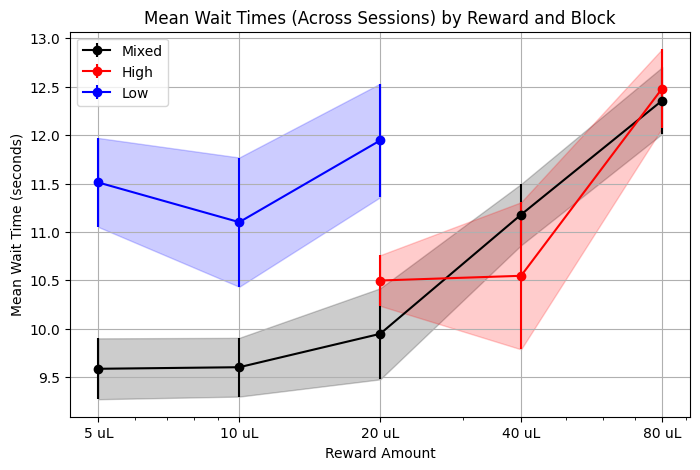

In [211]:
# calculate wait times matrix/curves per session
# then calculate standard error across sessions, not per session

# create a matrix to hold mean wait times for each block and reward combination per session
wait_times_per_session = np.zeros((num_sessions, len(unique_blocks), len(unique_rewards)))

for session in range(num_sessions):
    # take the subset of the dataframe for the current session
    session_data = beh_df[beh_df['session_num'] == session + 1]
    for i, block in enumerate(unique_blocks):
        for j, reward in enumerate(unique_rewards):
            # fill this in:
            # hint: you can use the same logic as before, but now use session_data instead of beh_df
            wait_times_per_session[session, i, j] = session_data['wait_time'][(session_data['optout']==1) & (session_data['block']==block) & (session_data['reward']==reward)].mean()

# calculate the mean wait times across sessions
mean_wait_times_per_session = np.nanmean(wait_times_per_session, axis=0)

# calculate standard error across sessions
wait_times_std_per_session = np.nanstd(wait_times_per_session, axis=0) / np.sqrt(np.sum(~np.isnan(wait_times_per_session), axis=0) - 1)

# plotting the wait times per session
plt.figure(figsize=(8, 5))
for i, block in enumerate(unique_blocks):
    # we can plot the standard error as a shaded area around the mean wait times
    plt.fill_between(unique_rewards,
                     mean_wait_times_per_session[i, :] - wait_times_std_per_session[i, :], # lower bound
                     mean_wait_times_per_session[i, :] + wait_times_std_per_session[i, :], # upper bound
                     alpha=0.2, color=block_colors[block], )
    # Plot mean wait times with error bars across sessions
    plt.errorbar(unique_rewards, mean_wait_times_per_session[i, :], yerr=wait_times_std_per_session[i, :], fmt='o-', label=f'{block_labels[block]}', color=block_colors[block])
plt.xlabel('Reward Amount')
plt.ylabel('Mean Wait Time (seconds)')

# convert x-scale to log scale
plt.xscale('log')
plt.title('Mean Wait Times (Across Sessions) by Reward and Block')

# Set x-ticks to be the unique rewards
plt.xticks(unique_rewards, [f'{int(r)} uL' for r in unique_rewards])

plt.legend()
plt.grid(True)


Text(0, 0.5, 'Slope of wait times for mixed block')

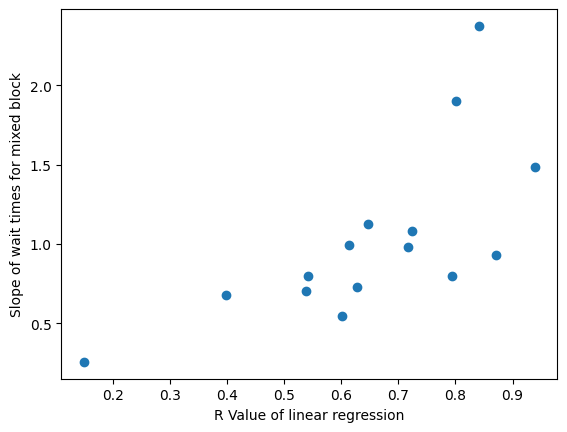

In [212]:
# calculate the slope of wait times for mixed block per session
slope_per_session = np.zeros(num_sessions)
r_value_per_session = np.zeros(num_sessions)

for session in range(num_sessions):
    slope, intercept, r_value, p_value, std_err = linregress(np.log(unique_rewards), wait_times_per_session[session, 0, :])
    slope_per_session[session] = slope
    r_value_per_session[session] = r_value

plt.scatter(r_value_per_session, slope_per_session, )
plt.xlabel('R Value of linear regression')
plt.ylabel('Slope of wait times for mixed block')

## sensitivity across sessions
Q: what do you notice about sessions with low r-value versus high r-value?
Low r-value sessions show flatter slopes, meaning rats weren’t as sensitive to reward. In contrast, high r-value sessions have steeper slopes, showing consistent increases in wait time with reward size.

Q: why did we look at r-value?
To measure how well wait times followed a consistent linear trend across rewards in each session.

Q: are there differences between per-session data versus combined 15-session data?
Yes. Per-session data shows individual variability in sensitivity to reward, while the combined data averages across sessions and smooths out those differences, potentially masking individual patterns.

# reward poke probability

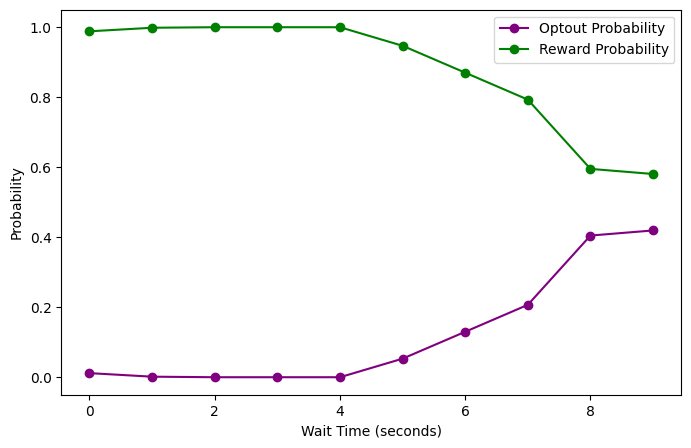

In [213]:
# how likely is it that the animal will go to the optout port, given how much time has elapsed (wait time)?

# for each wait time, on what proportion of trials does the animal go to the optout port versus it get rewarded?

# let's bin the wait times from 0 to 10 seconds in 0.5 second bins
wait_time_bins = np.arange(0, 10.5, 1)

# create a matrix to hold the probability of going to the optout port for each wait time bin
optout_prob = np.zeros(len(wait_time_bins)-1)

# loop through each bin and calculate the probability of going to the optout port, exclude violations and catch trials
for i in range(len(wait_time_bins)-1):
    # get the trials that fall within the current bin
    trials_in_bin = beh_df[(beh_df['wait_time'] >= wait_time_bins[i]) & (beh_df['wait_time'] < wait_time_bins[i+1]) &  (beh_df['vios'] == 0) & (beh_df['catch'] == 0)]

    # calculate the probability of going to the optout port
    optout_prob[i] = trials_in_bin['optout'].mean() if len(trials_in_bin) > 0 else np.nan

# the probability of getting reward is 1 - probability of going to the optout port
reward_prob = 1 - optout_prob

# let's plot both the probability of going to the optout port and the probability of getting reward as a function of wait time
plt.figure(figsize=(8, 5))
plt.plot(wait_time_bins[:-1], optout_prob, marker='o', linestyle='-', color='purple', label='Optout Probability')
plt.plot(wait_time_bins[:-1], reward_prob, marker='o', linestyle='-', color='green', label='Reward Probability')
plt.xlabel('Wait Time (seconds)')
plt.ylabel('Probability')
plt.legend()



# Multi-rat analyses

to analyse many files, we will create functions for each kind of analysis that we can call again and again on any data file or data frame

In [214]:
def load_behavior_data(file_path):
    """
    Load behavior data from a .mat file and return a pandas DataFrame
    with standardized reward levels and session numbers.

    Parameters:
    file_path (str): Path to the .mat file.

    Returns:
    pd.DataFrame: DataFrame containing the behavior data.
    """

    data = loadmat(file_path)
    beh = data['A'][0, 0]

    fieldnames = ['catch', 'reward', 'reward_delay', 'block', 'hits', 'vios', 'optout',
                  'wait_time', 'trial_num', 'ITI', 'BlockNum', 'BlockPosition']
    beh_df = pd.DataFrame({field: beh[field].flatten() for field in fieldnames})

    # Map reward values to standard set
    original_rewards = np.sort(np.unique(beh_df['reward']))
    standard_rewards = [5, 10, 20, 40, 80][:len(original_rewards)]

    reward_mapping = {orig: std for orig, std in zip(original_rewards, standard_rewards)}
    beh_df['reward'] = beh_df['reward'].map(reward_mapping)

    # Add session number based on trial_num resets
    restarts = np.where(beh_df['trial_num'] == 1)[0]
    num_sessions = len(restarts)
    beh_df['session_num'] = 0
    for i in range(num_sessions):
        start = restarts[i]
        end = restarts[i + 1] if (i < num_sessions - 1) else len(beh_df)
        beh_df.loc[start:end - 1, 'session_num'] = i + 1

    return beh_df

In [215]:
# create a function to plot wait times by block and reward using combined data across sessions
def plot_wait_times_aggrgated( beh_df, block_labels = {1: 'Mixed', 2: 'High', 3: 'Low'}, block_colors = {1: 'black', 2: 'red', 3: 'blue'} ):
    """
    Plot mean wait times by block and reward using aggregated data across sessions.
    
    Parameters:
    beh_df (pd.DataFrame): DataFrame containing the behavior data.
    block_labels (dict): Dictionary mapping block numbers to labels.
    block_colors (dict): Dictionary mapping block numbers to colors.
    """
    
    unique_blocks = np.sort(beh_df['block'].unique())
    unique_rewards = np.sort(beh_df['reward'].unique())

    # create a matrix to hold mean wait times for each block and reward combination
    wait_times = np.zeros((len(unique_blocks), len(unique_rewards)))
    wait_times_std = np.zeros((len(unique_blocks), len(unique_rewards)))

    for i, block in enumerate(unique_blocks):
        for j, reward in enumerate(unique_rewards):        
            wait_times[i, j] = beh_df['wait_time'][(beh_df['optout']==1) & (beh_df['block']==block) & (beh_df['reward']==reward)].mean()
            wait_times_std[i, j] = beh_df['wait_time'][(beh_df['optout']==1) & (beh_df['block']==block) & (beh_df['reward']==reward)].sem()

    # plotting the wait times
    plt.figure(figsize=(3, 3))
    for i, block in enumerate(unique_blocks):
        plt.errorbar(unique_rewards, wait_times[i, :], yerr=wait_times_std[i, :], fmt='o-', label=f'{block_labels[block]}', color=block_colors[block])
    
    plt.xlabel('Reward Amount')
    plt.ylabel('Mean Wait Time (seconds)')
    
    # convert x-scale to log scale
    plt.xscale('log')

    # Set x-ticks to be the unique rewards
    plt.xticks(unique_rewards, [f'{int(r)} uL' for r in unique_rewards])

    plt.legend()
    plt.grid(True)

    # return the wait times matrix and standard error
    return wait_times, wait_times_std

Loading data from file: ExampleData/ratTrial_G120Last15.mat


Text(0.5, 0.98, 'G120Last15')

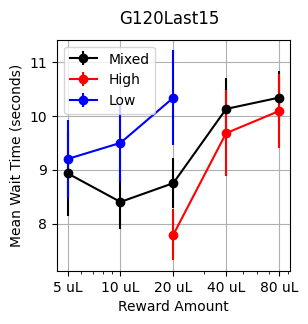

In [216]:
# now let's try this on a new file
fnum = 7 # <------ try a different file 
file = all_files[fnum]
fname = file.split('/')[-1].split('.')[0]  # Extract filename without extension
rat_id = fname.split('_')[1]

print(f'Loading data from file: {file}')
beh_df = load_behavior_data(file)
wait_times, wait_times_std = plot_wait_times_aggrgated(beh_df)
plt.suptitle(rat_id, fontsize=12)


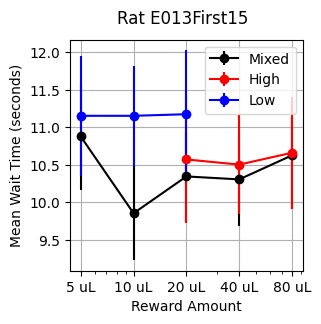

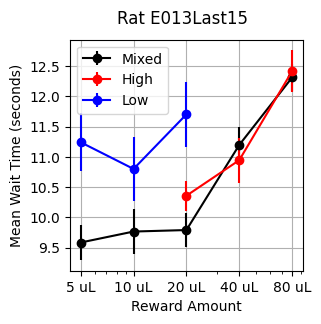

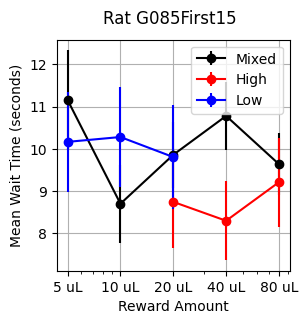

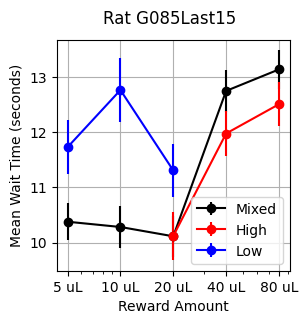

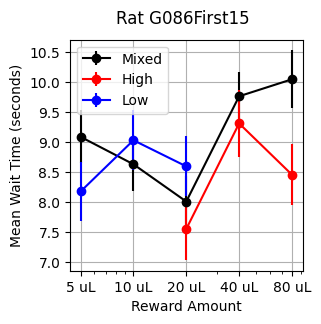

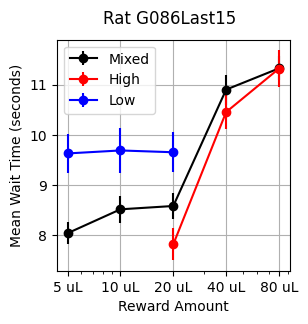

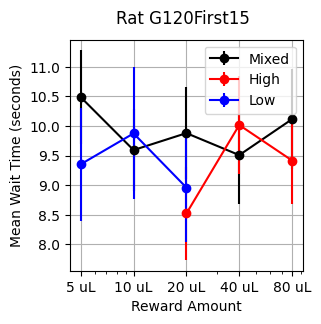

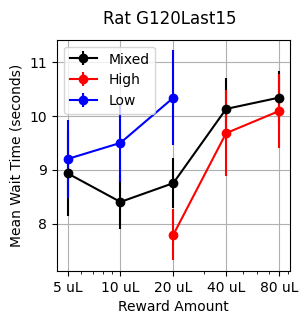

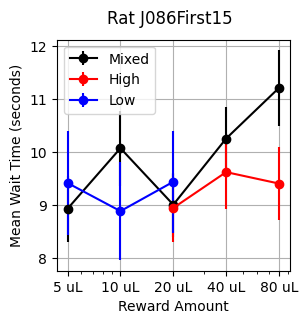

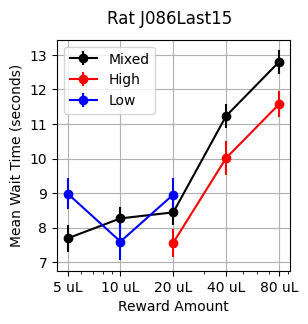

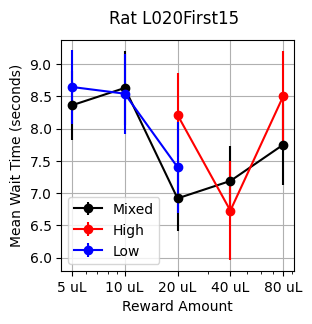

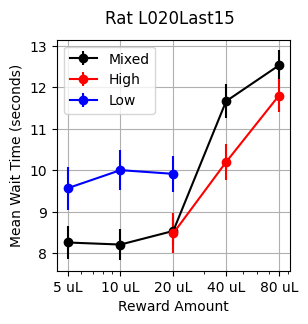

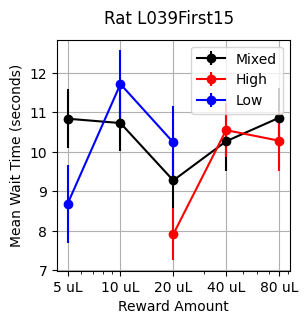

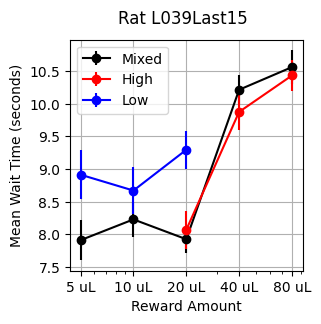

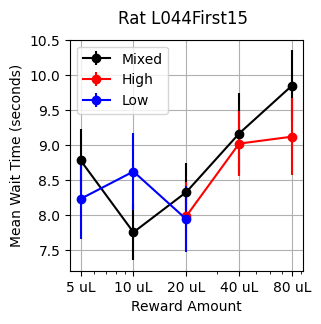

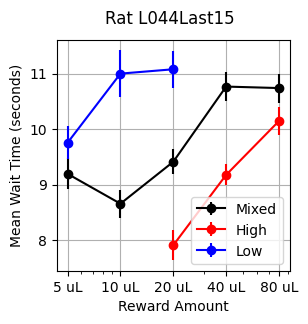

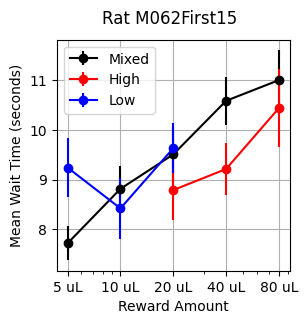

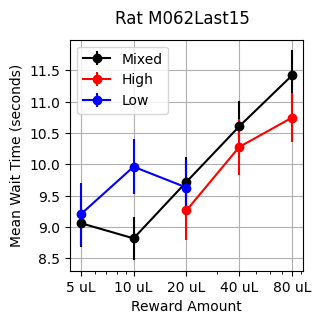

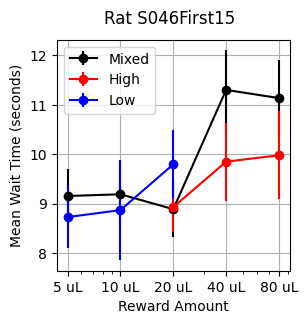

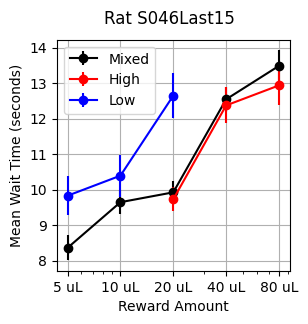

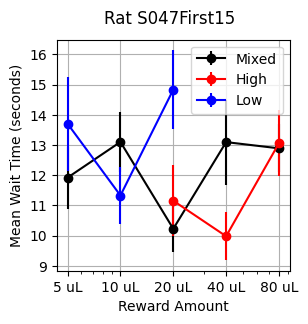

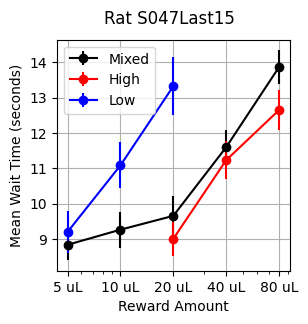

In [217]:
# loop through all files and plot wait times

for file in all_files:
    # Extract file name and rat ID
    fname = file.split('/')[-1].split('.')[0]
    rat_id = fname.split('_')[1]

    # Load behavior data
    beh_df = load_behavior_data(file)

    # Plot aggregated wait times
    wait_times, wait_times_std = plot_wait_times_aggrgated(beh_df)
    plt.suptitle(f'Rat {rat_id}', fontsize=12)
    plt.show()

Q: can you modify the function so that you pass a figure and axes to the function, and it plots on that figure and axis?
so that you can create a grid of subplots with multiple rats on the same figure?

In [218]:
# new function that also takes a figure and axes as input
def plot_wait_times_aggrgated(beh_df, ax, block_labels={1: 'Mixed', 2: 'High', 3: 'Low'}, block_colors={1: 'black', 2: 'red', 3: 'blue'}):

    unique_blocks = np.sort(beh_df['block'].unique())
    unique_rewards = np.sort(beh_df['reward'].unique())

    # create a matrix to hold mean wait times for each block and reward combination
    wait_times = np.zeros((len(unique_blocks), len(unique_rewards)))
    wait_times_std = np.zeros((len(unique_blocks), len(unique_rewards)))

    for i, block in enumerate(unique_blocks):
        for j, reward in enumerate(unique_rewards):        
            wait_times[i, j] = beh_df['wait_time'][(beh_df['optout']==1) & (beh_df['block']==block) & (beh_df['reward']==reward)].mean()
            wait_times_std[i, j] = beh_df['wait_time'][(beh_df['optout']==1) & (beh_df['block']==block) & (beh_df['reward']==reward)].sem()

    # plot on the provided axis
    for i, block in enumerate(unique_blocks):
        ax.errorbar(unique_rewards, wait_times[i, :], yerr=wait_times_std[i, :], fmt='o-', label=block_labels[block], color=block_colors[block])

    ax.set_xlabel('Reward Amount')
    ax.set_ylabel('Mean Wait Time (s)')
    ax.set_xscale('log')
    ax.set_xticks(unique_rewards)
    ax.set_xticklabels([f'{int(r)} uL' for r in unique_rewards])
    ax.grid(True)
    
    return wait_times, wait_times_std

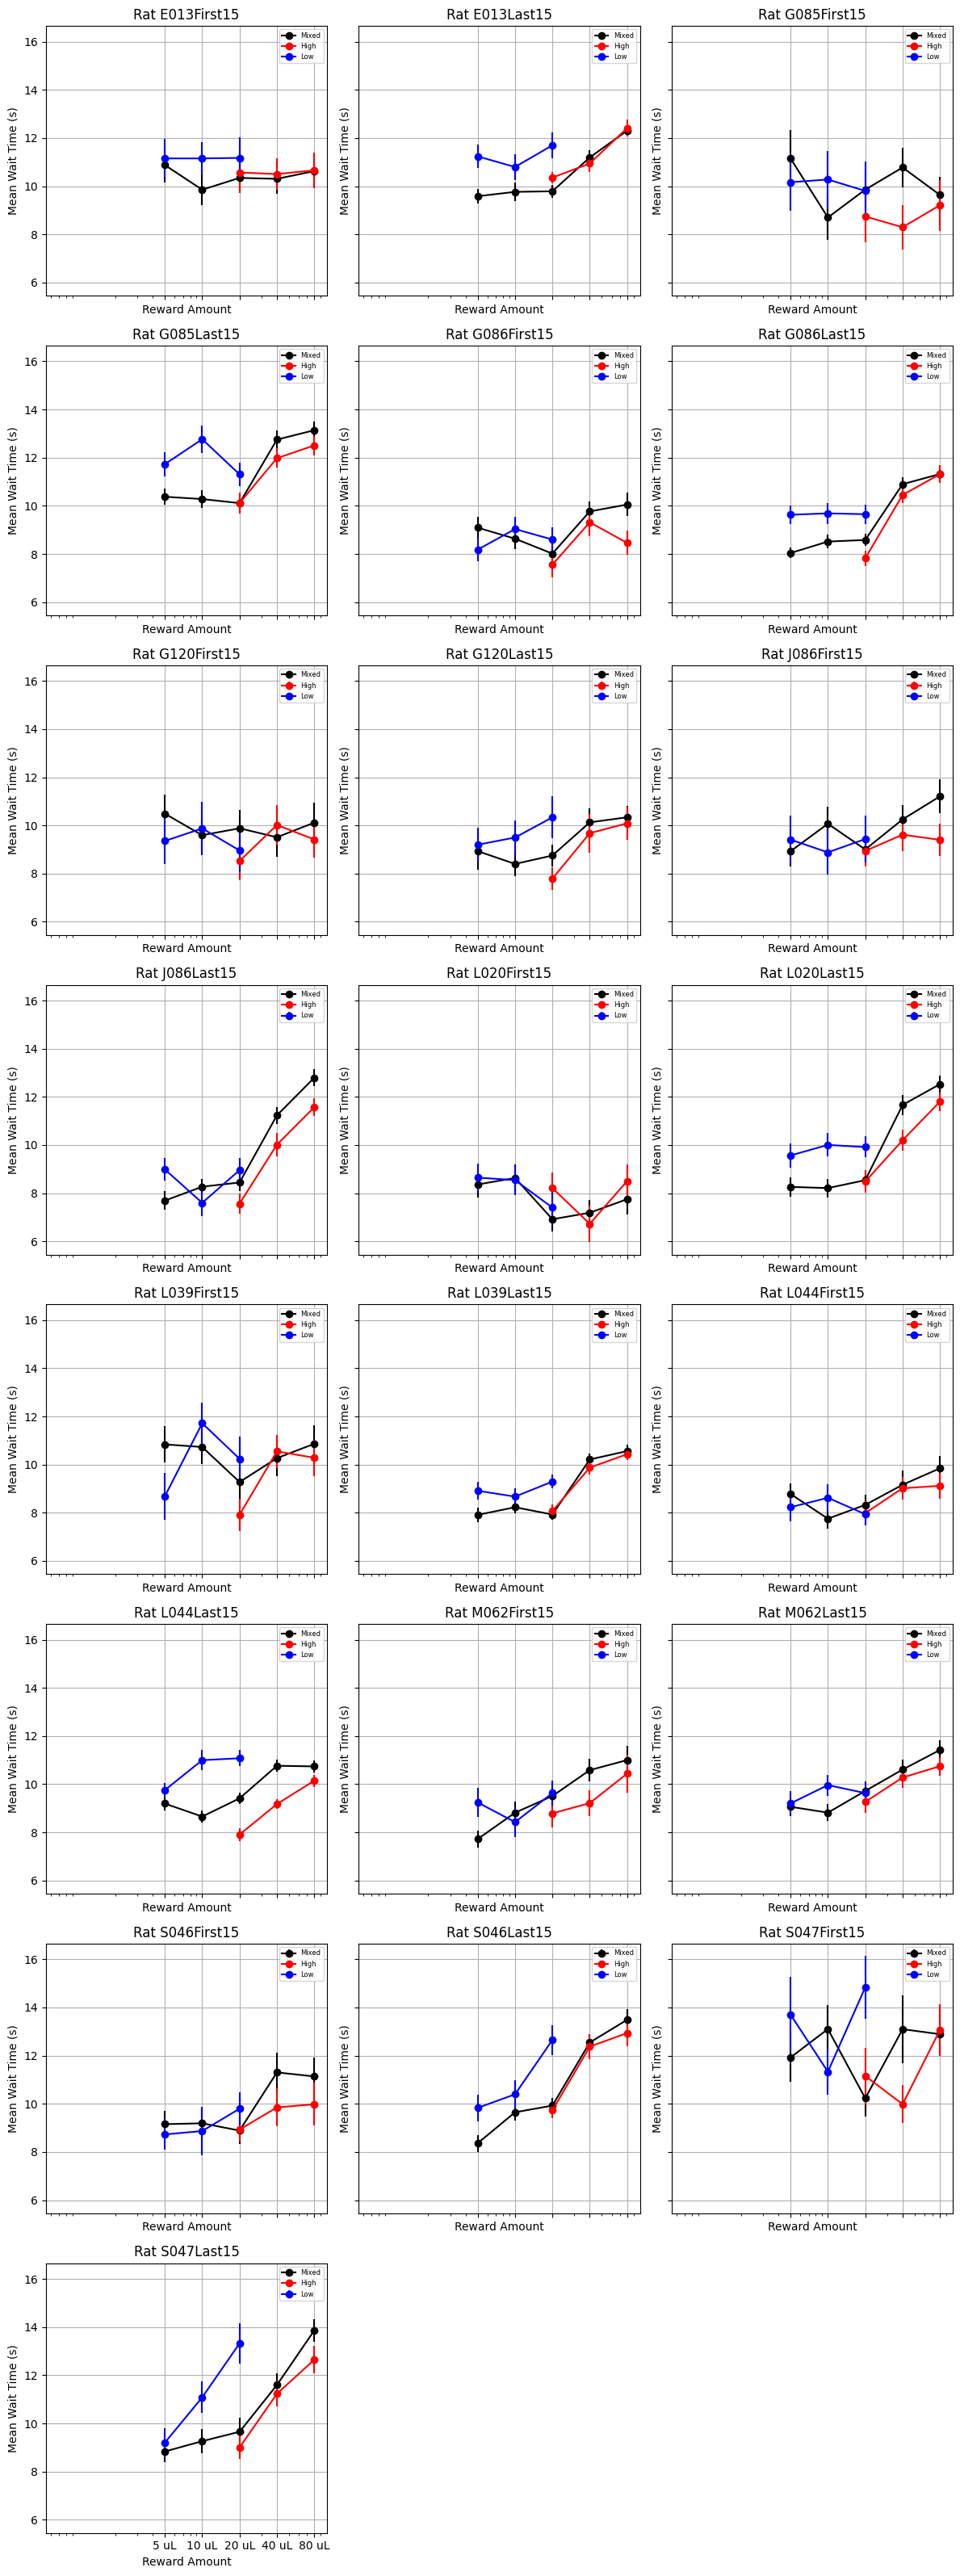

In [219]:
# creating grid of subplots with multiple rats on same figure
num_rats = len(all_files)
cols = 3
rows = int(np.ceil(num_rats / cols))

fig, axs = plt.subplots(rows, cols, figsize=(cols * 4, rows * 4), sharex=True, sharey=True)

axs = axs.flatten()

for i, file in enumerate(all_files):
    beh_df = load_behavior_data(file)
    rat_id = file.split('/')[-1].split('.')[0].split('_')[1]
    plot_wait_times_aggrgated(beh_df, axs[i])
    axs[i].set_title(f'Rat {rat_id}')
    axs[i].legend(fontsize=6)

# hide unused subplots
for j in range(i + 1, len(axs)):
    fig.delaxes(axs[j])

fig.tight_layout()
plt.show()

Q: calculate stats on the wait time matrix

In [220]:
valid_values = wait_times[~np.isnan(wait_times)]
mean_wait = np.mean(valid_values)
std_wait = np.std(valid_values)
num_values = len(valid_values)

print("Mean wait time:", mean_wait)
print("Stdev:", std_wait)
print("Number of valid entries:", num_values)

Mean wait time: 10.879733827354565
Stdev: 1.740050002760951
Number of valid entries: 11


In [221]:
# write a function to calculate block sensitivity, as well as slope of wait times for mixed block with data combined across session
def calc_block_sensitivity_and_mixed_slope(beh_df):
    """
    Calculate block sensitivity and slope of wait times for mixed block with data combined across sessions.
    
    Parameters:
    beh_df (pd.DataFrame): DataFrame containing the behavior data.
    
    Returns:
    block_sensitivity (float): Difference in wait times between Low and High blocks at 20 µL.
    block_sensitivity_ratio (float): Ratio of wait times between Low and High blocks at 20 µL.
    slope (float): Slope of wait times for mixed block across reward levels.
    """
    
    unique_blocks = np.sort(beh_df['block'].unique())
    unique_rewards = np.sort(beh_df['reward'].unique())
    wait_times = np.full((len(unique_blocks), len(unique_rewards)), np.nan)

    for i, block in enumerate(unique_blocks):
        for j, reward in enumerate(unique_rewards):
            mask = (beh_df['optout']==1) & (beh_df['block']==block) & (beh_df['reward']==reward)
            vals = beh_df.loc[mask, 'wait_time']
            if len(vals):
                wait_times[i, j] = vals.mean()

    # block sensitivity at 20 µL: Low (block==3) minus High (block==2)
    idx20 = np.where(unique_rewards==20)[0][0]
    low_i  = np.where(unique_blocks==3)[0][0]
    high_i = np.where(unique_blocks==2)[0][0]
    block_sensitivity = wait_times[low_i, idx20] - wait_times[high_i, idx20]

    # ratio version of block sensitivity: Low divided by High
    block_sensitivity_ratio = wait_times[low_i, idx20] / wait_times[high_i, idx20]

    # slope for Mixed block (block==1)
    mix_i = np.where(unique_blocks==1)[0][0]
    y = wait_times[mix_i]
    x = np.log(unique_rewards)
    mask = ~np.isnan(y)
    slope, _, _, _, _ = linregress(x[mask], y[mask])

    return block_sensitivity, block_sensitivity_ratio, slope


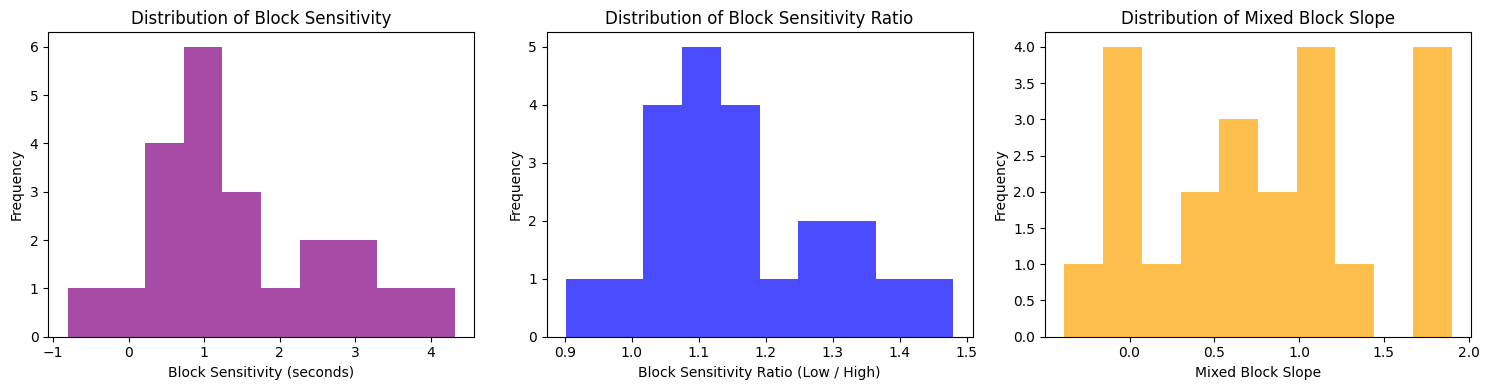

Block sensitivity values: 22
Block sensitivity ratios: 22
Mixed slope values: 22


In [222]:
# call the function to calculate block sensitivity and slope of wait times for mixed block for all files
block_sensitivities = []
block_sensitivity_ratios = []
mixed_slopes = []

for file in all_files:
    beh_df = load_behavior_data(file)
    
    # Check if 20 µL reward exists in the data
    if 20 not in beh_df['reward'].values:
        continue
        
    # Check if required blocks exist
    if not all(block in beh_df['block'].values for block in [1, 2, 3]):
        continue
        
    block_sensitivity, block_sensitivity_ratio, mixed_slope = calc_block_sensitivity_and_mixed_slope(beh_df)
    
    # only add if values are valid (not NaN or inf)
    if not np.isnan(block_sensitivity):
        block_sensitivities.append(block_sensitivity)
    if not np.isnan(block_sensitivity_ratio) and np.isfinite(block_sensitivity_ratio):
        block_sensitivity_ratios.append(block_sensitivity_ratio)
    if not np.isnan(mixed_slope):
        mixed_slopes.append(mixed_slope)

# plot the distribution of block sensitivity, ratio, and slope across all files
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4))

# block sensitivity distribution
if len(block_sensitivities) > 0:
    ax1.hist(block_sensitivities, bins=10, alpha=0.7, color='purple')
    ax1.set_xlabel('Block Sensitivity (seconds)')
    ax1.set_ylabel('Frequency')
    ax1.set_title('Distribution of Block Sensitivity')
else:
    ax1.text(0.5, 0.5, 'No valid block sensitivity data', ha='center', va='center', transform=ax1.transAxes)

# block sensitivity ratio distribution
if len(block_sensitivity_ratios) > 0:
    ax2.hist(block_sensitivity_ratios, bins=10, alpha=0.7, color='blue')
    ax2.set_xlabel('Block Sensitivity Ratio (Low / High)')
    ax2.set_ylabel('Frequency')
    ax2.set_title('Distribution of Block Sensitivity Ratio')
else:
    ax2.text(0.5, 0.5, 'No valid ratio data', ha='center', va='center', transform=ax2.transAxes)

# mixed slope distribution
if len(mixed_slopes) > 0:
    ax3.hist(mixed_slopes, bins=10, alpha=0.7, color='orange')
    ax3.set_xlabel('Mixed Block Slope')
    ax3.set_ylabel('Frequency')
    ax3.set_title('Distribution of Mixed Block Slope')
else:
    ax3.text(0.5, 0.5, 'No valid mixed slope data', ha='center', va='center', transform=ax3.transAxes)

plt.tight_layout()
plt.show()

print(f"Block sensitivity values: {len(block_sensitivities)}")
print(f"Block sensitivity ratios: {len(block_sensitivity_ratios)}")
print(f"Mixed slope values: {len(mixed_slopes)}")

# Observations:
- higher block sensitivity means rats waited longer in low than high blocks at 20 µL

- most rats had positive block sensitivity

- approximately 1 rat had slightly negative sensitivity

- most ratios were greater than 1, showing longer waits in low vs high block

- mixed block slopes mostly positive

- steeper slopes mean stronger reward sensitivity

- barely any rat showed little or no slope; most showed a slope

- overall shows variability in both block and reward effects across rats

In [223]:
# write a function to plot wait times per session
def plot_wait_times_per_session(beh_df, block_labels={1: 'Mixed', 2: 'High', 3: 'Low'}, block_colors={1: 'black', 2: 'red', 3: 'blue'}):
    """
    Plot mean wait times by block and reward using data per sessions.
    
    Parameters:
    beh_df (pd.DataFrame): DataFrame containing the behavior data.
    block_labels (dict): Dictionary mapping block numbers to labels.
    block_colors (dict): Dictionary mapping block numbers to colors.

    Returns:
    wait_times_per_session (np.ndarray): A 3D array containing mean wait times for each session, block, and reward combination.
    """

    unique_blocks = np.sort(beh_df['block'].unique())
    unique_rewards = np.sort(beh_df['reward'].unique())
    num_sessions = beh_df['session_num'].nunique()
    print(f'Number of sessions: {num_sessions}')

    wait_times_per_session = np.zeros((num_sessions, len(unique_blocks), len(unique_rewards)))

    # loop through each session and calculate mean wait times
    # fill out the code here
    for session in range(num_sessions):
        for i, block in enumerate(unique_blocks):
            for j, reward in enumerate(unique_rewards):
                mask = (
                    (beh_df['session_num'] == session) &
                    (beh_df['block'] == block) &
                    (beh_df['reward'] == reward) &
                    (beh_df['optout'] == 1)
                )
                vals = beh_df.loc[mask, 'wait_time']
                if len(vals) > 0:
                    wait_times_per_session[session, i, j] = vals.mean()

    return wait_times_per_session 

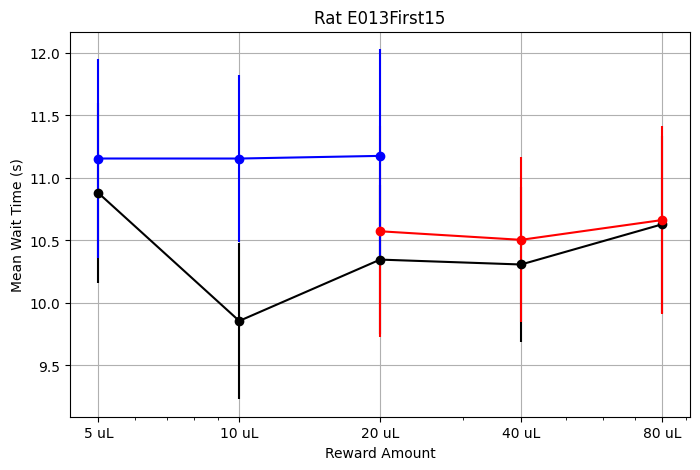

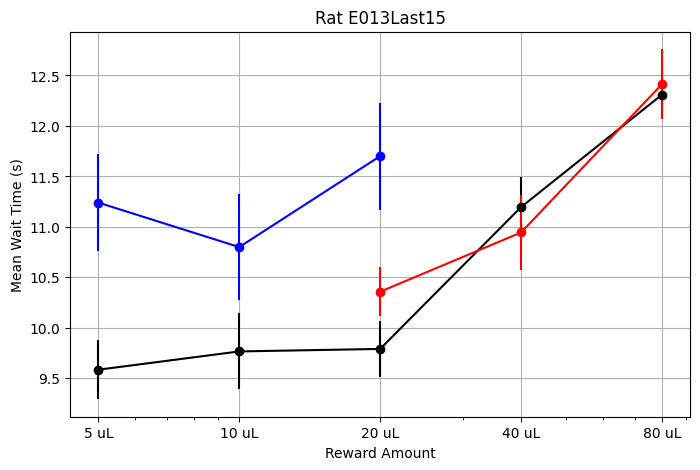

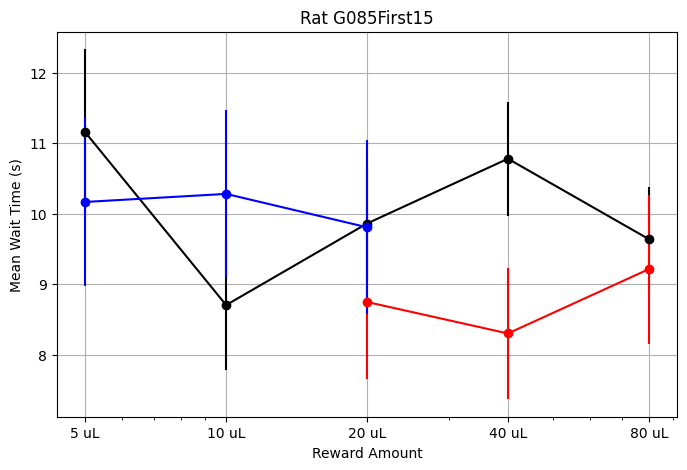

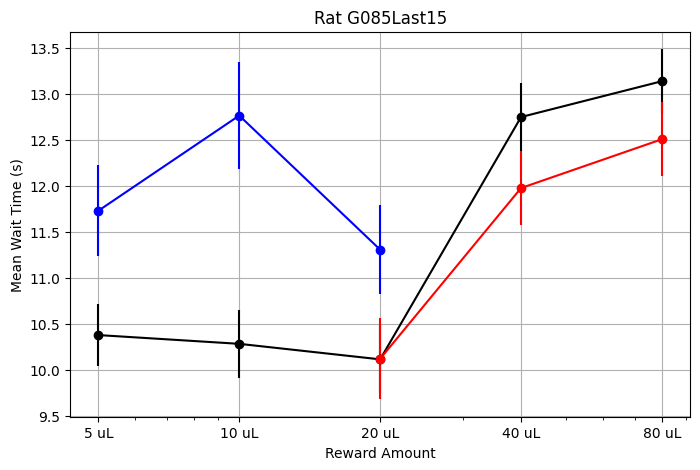

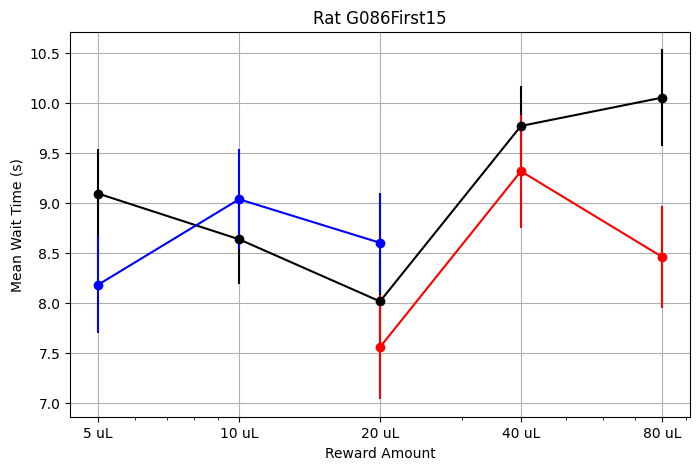

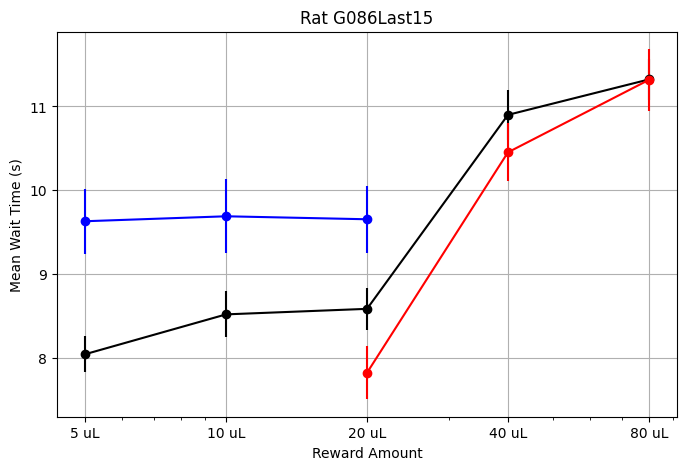

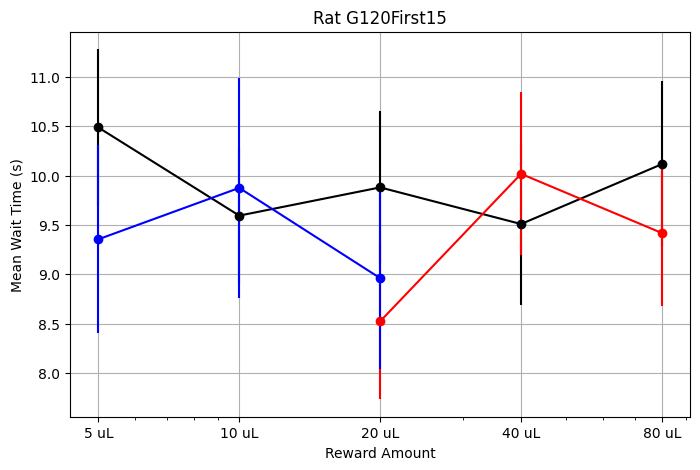

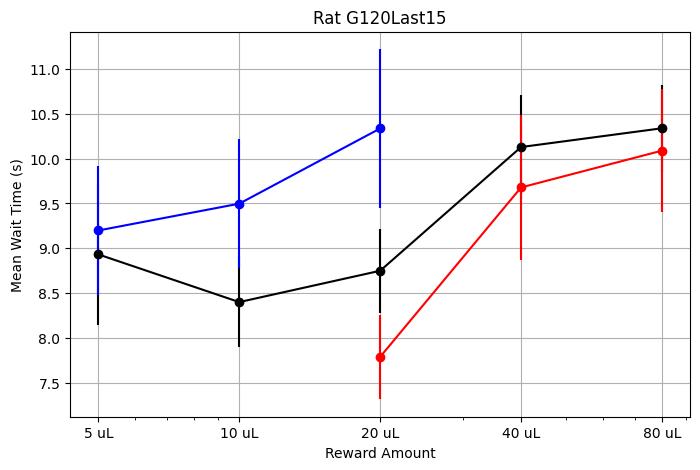

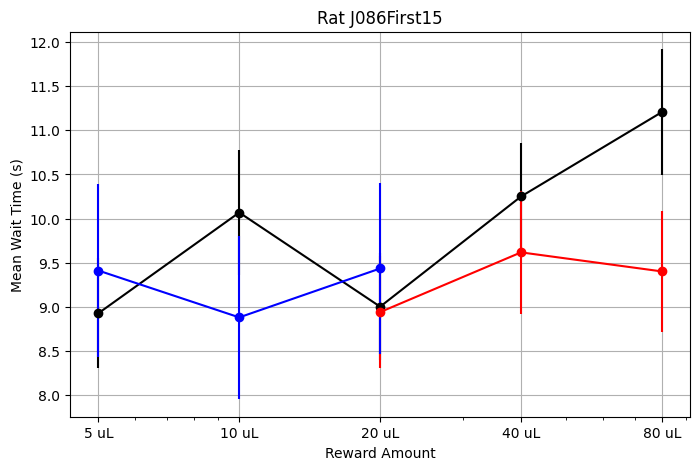

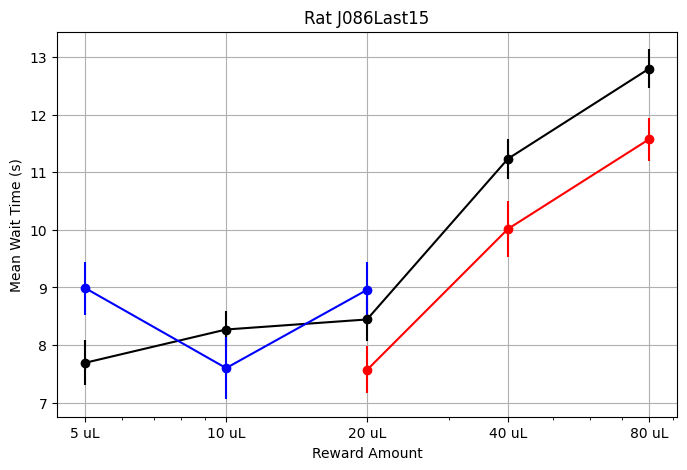

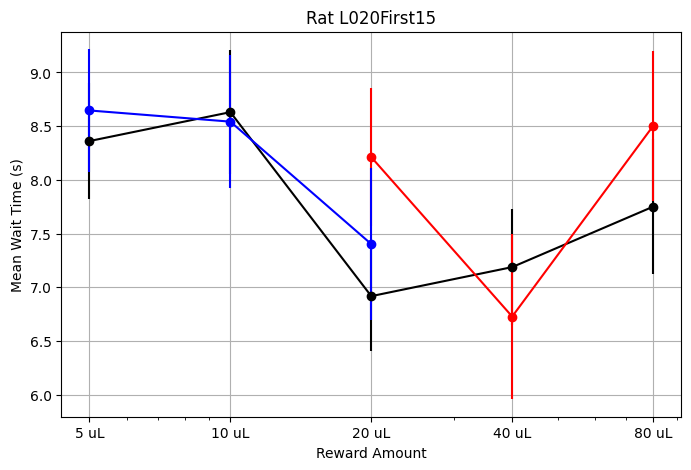

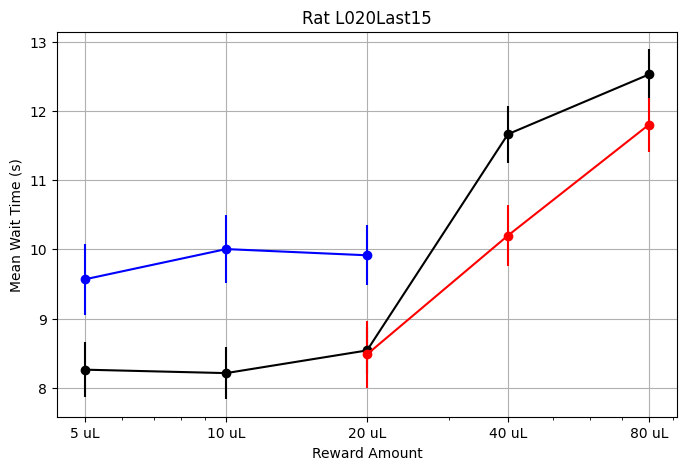

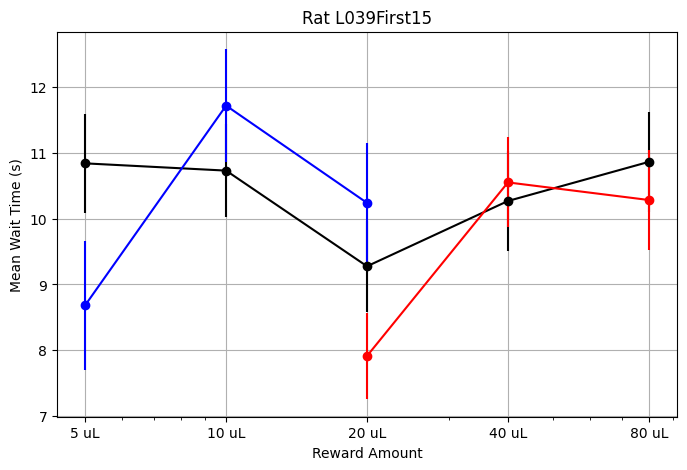

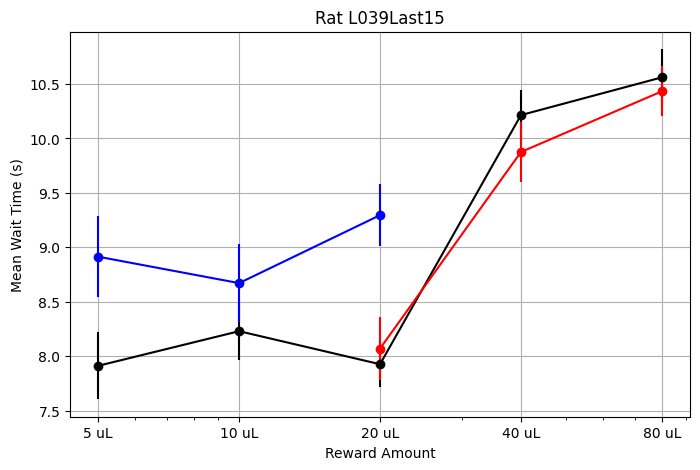

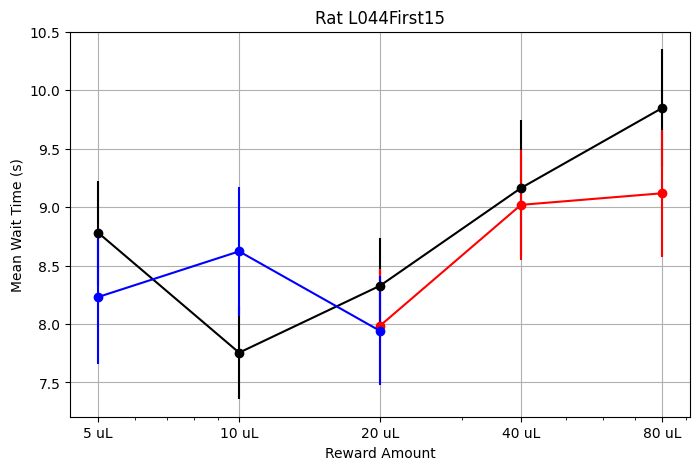

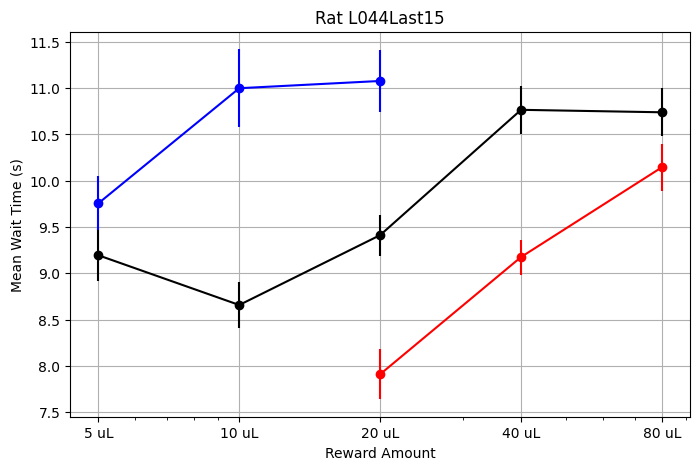

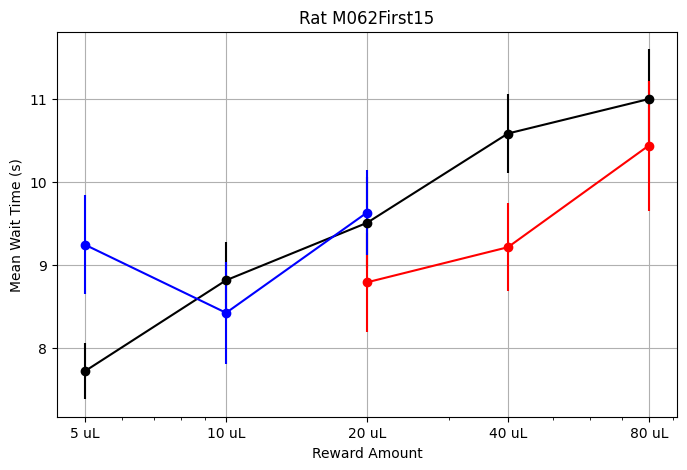

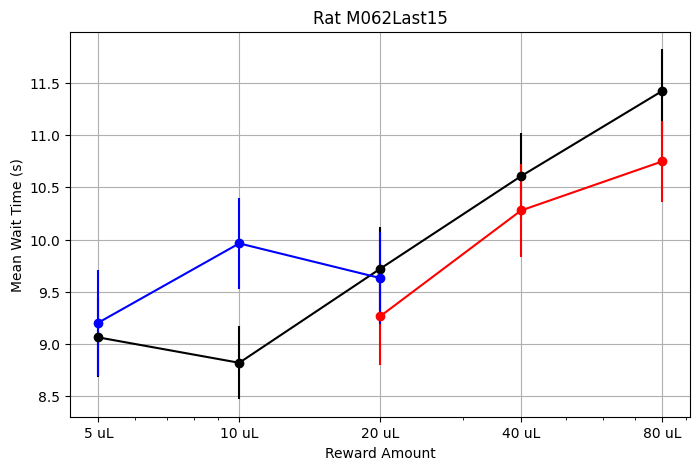

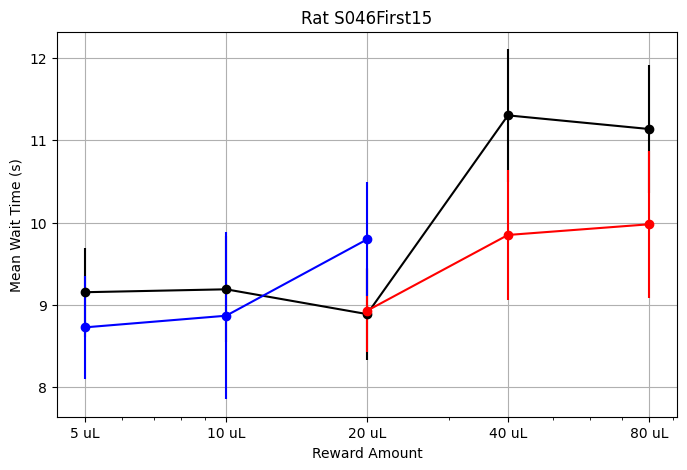

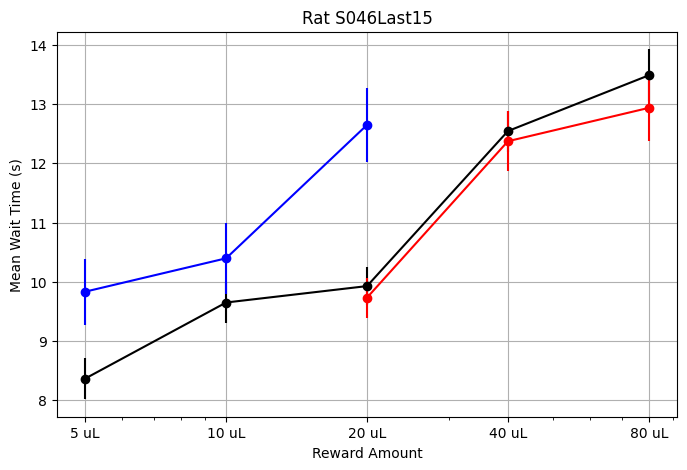

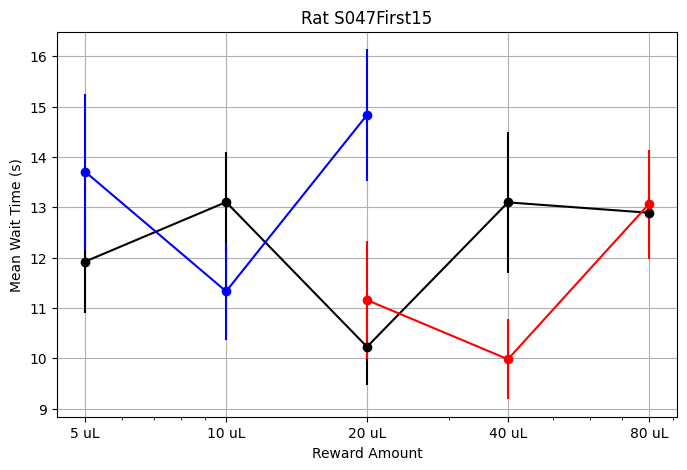

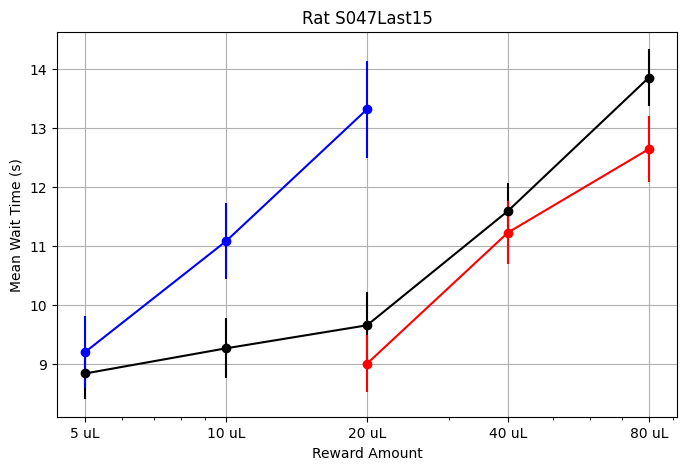

In [224]:
# loop through all files and plot wait times
for file in all_files:
    fname = file.split('/')[-1].split('.')[0]
    rat_id = fname.split('_')[1]
    
    beh_df = load_behavior_data(file)
    
    # create new figure for each rat
    fig, ax = plt.subplots(figsize=(8, 5))
    wait_times, wait_times_std = plot_wait_times_aggrgated(beh_df, ax)
    ax.set_title(f'Rat {rat_id}')
    plt.show()

In [225]:
# write a function to calculate slope of wait times for mixed block per session 
def calc_mixed_slope_per_session(beh_df):
    """
    Calculate the slope of wait times for mixed block per session,
    excluding violations and wait times > 30 seconds.

    Returns:
    slopes (np.array): Array of slopes for each session.
    """

    unique_rewards = np.sort(beh_df['reward'].unique())
    num_sessions = beh_df['session_num'].nunique()
    slopes = np.full(num_sessions, np.nan)

    for session in range(num_sessions):
        wait_times_mixed = np.full(len(unique_rewards), np.nan)

        for j, reward in enumerate(unique_rewards):
            mask = (
                (beh_df['session_num'] == session + 1) &
                (beh_df['block'] == 1) &  # Mixed block
                (beh_df['reward'] == reward) &
                (beh_df['optout'] == 1) &
                (beh_df['vios'] == 0) &
                (beh_df['wait_time'] <= 30)
            )
            vals = beh_df.loc[mask, 'wait_time']
            if len(vals) > 0:
                wait_times_mixed[j] = vals.mean()

        valid_mask = ~np.isnan(wait_times_mixed)
        if np.sum(valid_mask) > 1:
            slope, _, _, _, _ = linregress(np.log(unique_rewards[valid_mask]), wait_times_mixed[valid_mask])
            slopes[session] = slope

    return slopes

# write a function to calculate block sensitivity (Low - High wait time at 20 uL) and ratio per session

In [226]:
def calc_block_sensitivity_per_session(beh_df):
    """
    Calculate block sensitivity per session (Low - High wait time at 20 uL),
    and the ratio (Low / High), excluding violations and wait times > 30 seconds.

    Returns:
    block_sens (np.ndarray): Difference in wait times per session.
    block_sens_ratio (np.ndarray): Ratio of wait times per session.
    """

    unique_rewards = np.sort(beh_df['reward'].unique())
    if 20 not in unique_rewards:
        n = beh_df['session_num'].nunique()
        return np.full(n, np.nan), np.full(n, np.nan)

    num_sessions = beh_df['session_num'].nunique()
    block_sens = np.full(num_sessions, np.nan)
    block_sens_ratio = np.full(num_sessions, np.nan)

    for session in range(num_sessions):
        session_data = beh_df[
            (beh_df['session_num'] == session + 1) &
            (beh_df['vios'] == 0) &
            (beh_df['wait_time'] <= 30)
        ]

        wait_low = session_data[
            (session_data['block'] == 3) &
            (session_data['reward'] == 20) &
            (session_data['optout'] == 1)
        ]['wait_time'].mean()

        wait_high = session_data[
            (session_data['block'] == 2) &
            (session_data['reward'] == 20) &
            (session_data['optout'] == 1)
        ]['wait_time'].mean()

        if pd.notna(wait_low) and pd.notna(wait_high) and wait_high != 0:
            block_sens[session] = wait_low - wait_high
            block_sens_ratio[session] = wait_low / wait_high

    return block_sens, block_sens_ratio


In [227]:
# write a function to get optout probability as a function of wait time
def get_optout_probability(beh_df, wait_time_bins=np.arange(0, 10.5, 1), ax=None):
    """
    Calculate the probability of going to the optout port and the probability of getting reward as a function of wait time.
    
    Parameters:
    beh_df (pd.DataFrame): DataFrame containing the behavior data.
    wait_time_bins (np.ndarray): Array of wait time bins.
    
    Returns:
    optout_prob (np.ndarray): Probability of going to the optout port for each wait time bin.
    reward_prob (np.ndarray): Probability of getting reward for each wait time bin.
    """
    
    optout_prob = np.zeros(len(wait_time_bins) - 1)  # Initialize with NaN values
    
    for i in range(len(wait_time_bins) - 1):
        trials_in_bin = beh_df[(beh_df['wait_time'] >= wait_time_bins[i]) & 
                               (beh_df['wait_time'] < wait_time_bins[i + 1]) & 
                               (beh_df['vios'] == 0) & 
                               (beh_df['catch'] == 0)]
            
        optout_prob[i] = trials_in_bin['optout'].mean() if len(trials_in_bin) > 10 else np.nan
    
    reward_prob = 1 - optout_prob

    # plotting the probabilities
    if ax is None:
        plt.figure(figsize=(4, 3))
        ax = plt.gca()
    ax.plot(wait_time_bins[:-1], optout_prob, marker='o', linestyle='-', color='purple', label='Optout Probability')
    ax.plot(wait_time_bins[:-1], reward_prob, marker='o', linestyle='-', color='green', label='Reward Probability')
    ax.set_xlabel('Wait Time (seconds)')
    ax.set_ylabel('Probability')

    return optout_prob, reward_prob

In [228]:

def get_optout_summary_stats(beh_df, wait_time_bins=np.arange(0, 10.5, 1)):
    """
    Extract opt-out probability characteristics and relate them to catch probability.

    Returns:
    dict: with prob_catch, threshold_time, post_threshold_slope
    """

    # calculate catch probability
    prob_catch = beh_df['catch'].mean()

    # bin opt-out probabilities
    optout_prob = np.zeros(len(wait_time_bins) - 1)
    for i in range(len(wait_time_bins) - 1):
        trials = beh_df[(beh_df['wait_time'] >= wait_time_bins[i]) & 
                        (beh_df['wait_time'] < wait_time_bins[i + 1]) & 
                        (beh_df['vios'] == 0) & 
                        (beh_df['catch'] == 0)]
        optout_prob[i] = trials['optout'].mean() if len(trials) > 10 else np.nan

    # threshold-time: first rise above 5% of max
    try:
        optout_max = np.nanmax(optout_prob)
        threshold_cutoff = 0.05 * optout_max

        above_cutoff = np.where(optout_prob > threshold_cutoff)[0]

        if len(above_cutoff) > 0:
            threshold_idx = above_cutoff[0]
            threshold_time = wait_time_bins[threshold_idx]
        else:
            threshold_time = np.nan

    except Exception:
        threshold_time = np.nan

    # estimate slope after that time (linear regression on post-threshold)
    x = wait_time_bins[:-1]
    y = optout_prob
    valid_idx = (x > threshold_time) & ~np.isnan(y)

    if np.sum(valid_idx) >= 2:
        slope, _, _, _, _ = linregress(x[valid_idx], y[valid_idx])
    else:
        slope = np.nan

    return {
        'prob_catch': prob_catch,
        'threshold_time': threshold_time,
        'post_threshold_slope': slope
    }

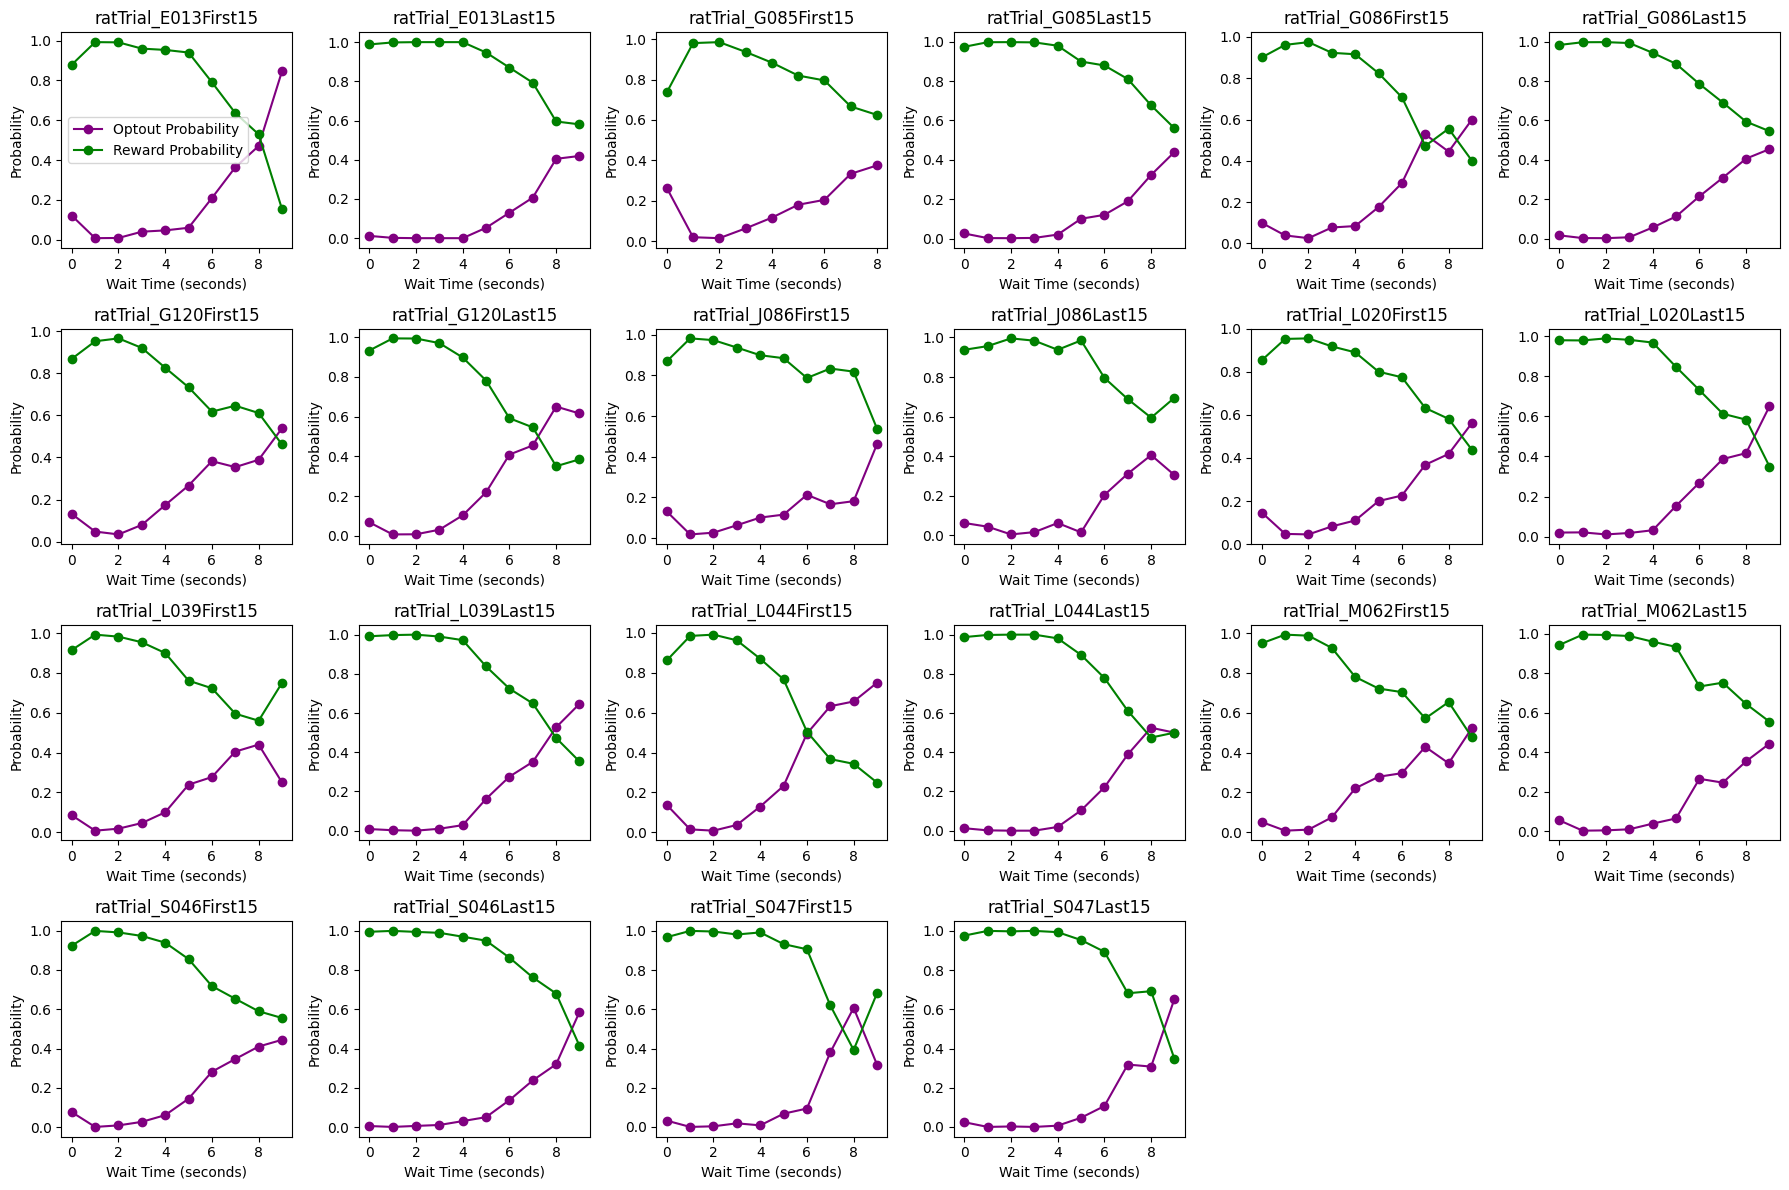

In [229]:
# loop through all files and plot optout probability
nfiles = len(all_files)

ncols = 6
nrows = np.ceil(nfiles / ncols).astype(int)
fig, axs = plt.subplots(nrows, ncols, figsize=(ncols * 3, nrows * 3))
axs = axs.flatten()  # flatten the array of axes for easy indexing

for i, file in enumerate(all_files):
    ax = axs[i]
    beh_df = load_behavior_data(file)
    optout_prob, reward_prob = get_optout_probability(beh_df, ax=ax)
    ax.set_title(file.split('/')[-1].split('.')[0], fontsize=12)
    if i == 0:
        ax.legend() # add legend only to the first subplot

for j in range(i + 1, len(axs)):
    axs[j].axis('off')  # hide unused subplots
plt.tight_layout()

In [230]:
# summarize optout behavior and catch prob per rat
summary_stats = []

for file in all_files:
    beh_df = load_behavior_data(file)
    stats = get_optout_summary_stats(beh_df)
    stats['rat'] = file.split('/')[-1].split('.')[0]
    summary_stats.append(stats)

summary_df = pd.DataFrame(summary_stats)
print(summary_df)

    prob_catch  threshold_time  post_threshold_slope                   rat
0     0.257670             0.0              0.092545  ratTrial_E013First15
1     0.234851             5.0              0.106632   ratTrial_E013Last15
2     0.326627             0.0              0.054357  ratTrial_G085First15
3     0.326276             0.0              0.053061   ratTrial_G085Last15
4     0.325379             0.0              0.076898  ratTrial_G086First15
5     0.266950             4.0              0.087472   ratTrial_G086Last15
6     0.244931             0.0              0.063047  ratTrial_G120First15
7     0.231966             0.0              0.091924   ratTrial_G120Last15
8     0.243054             0.0              0.042559  ratTrial_J086First15
9     0.231046             0.0              0.049639   ratTrial_J086Last15
10    0.166268             0.0              0.064414  ratTrial_L020First15
11    0.182388             5.0              0.117058   ratTrial_L020Last15
12    0.246089           

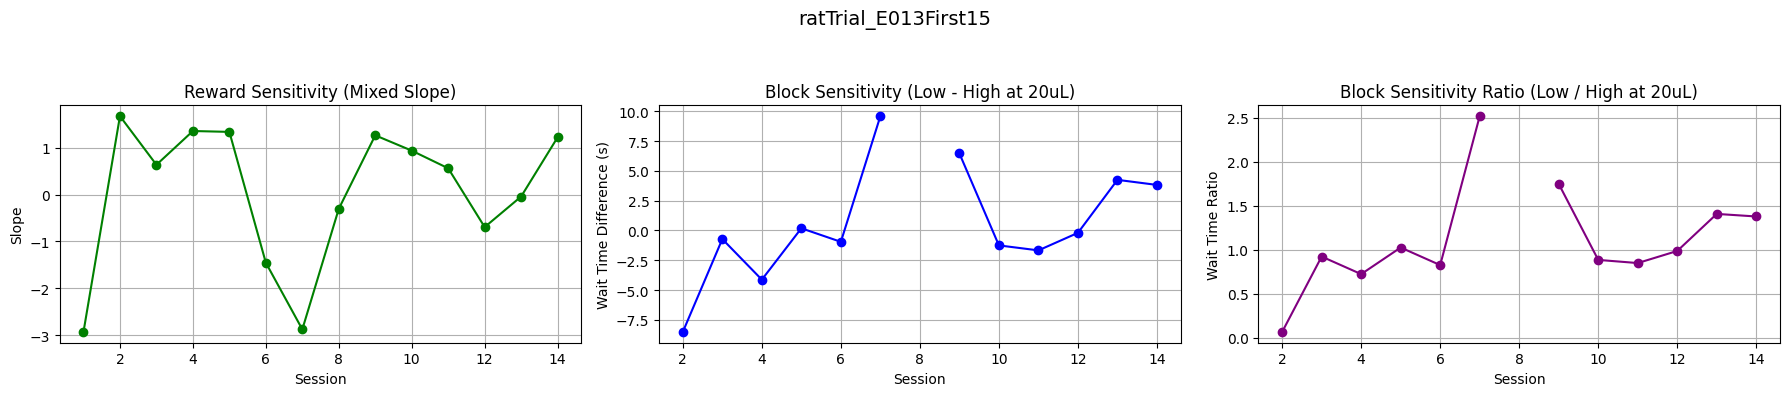

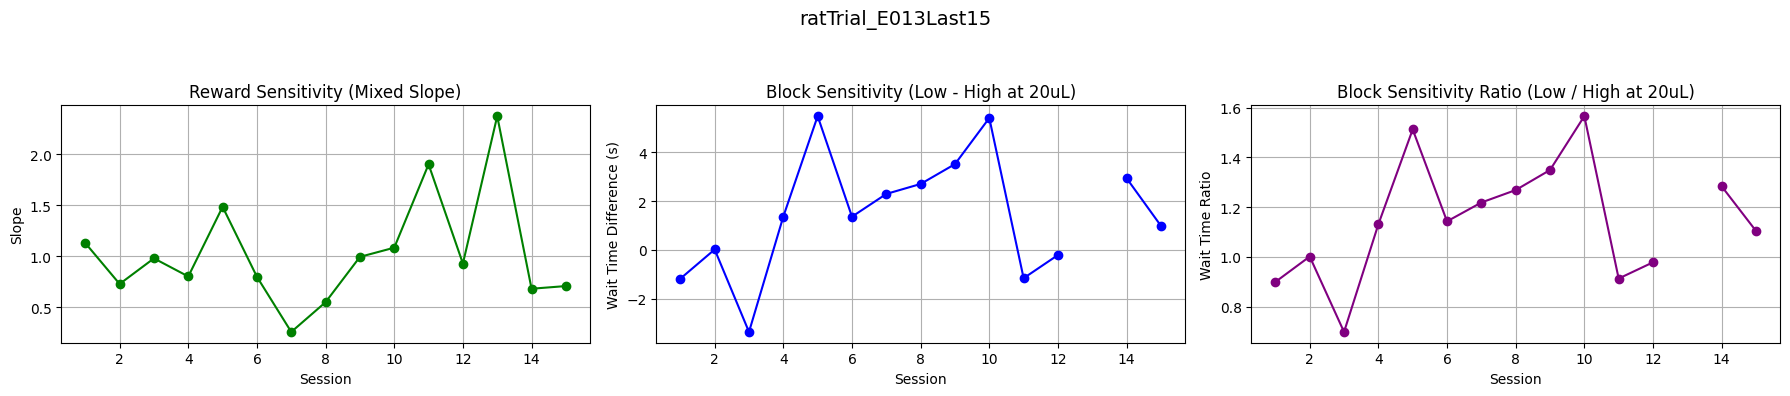

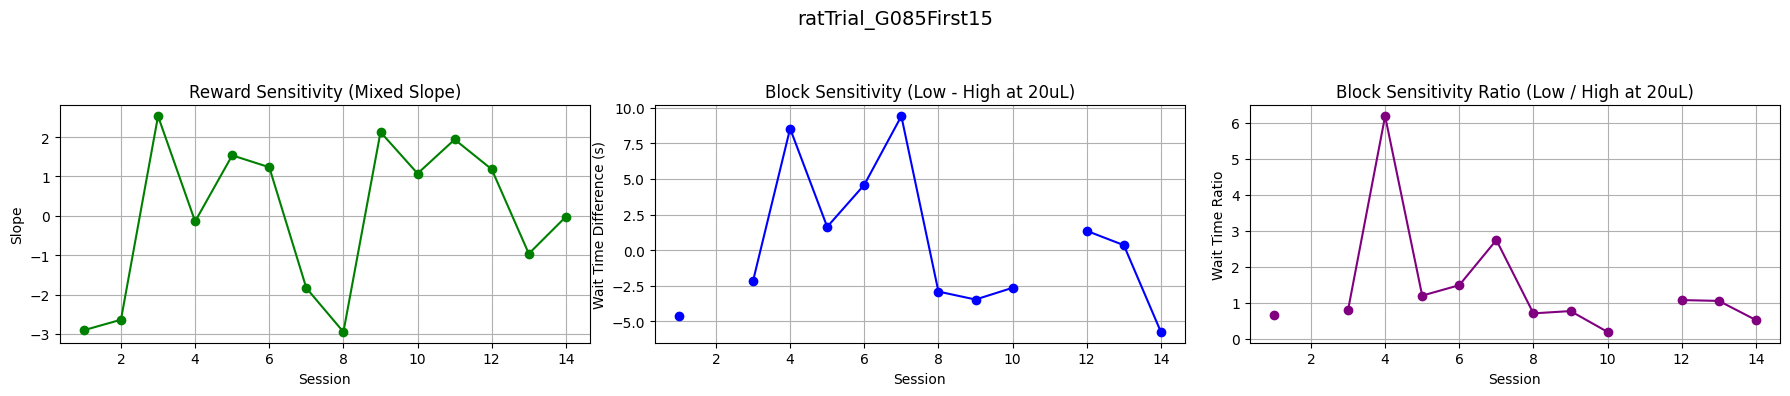

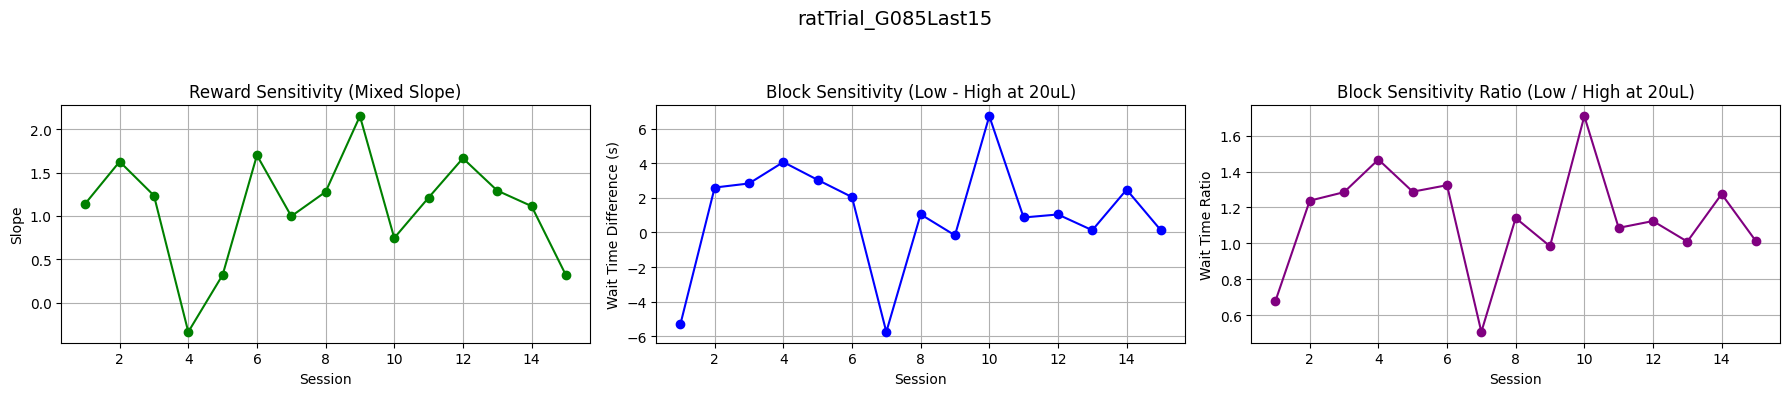

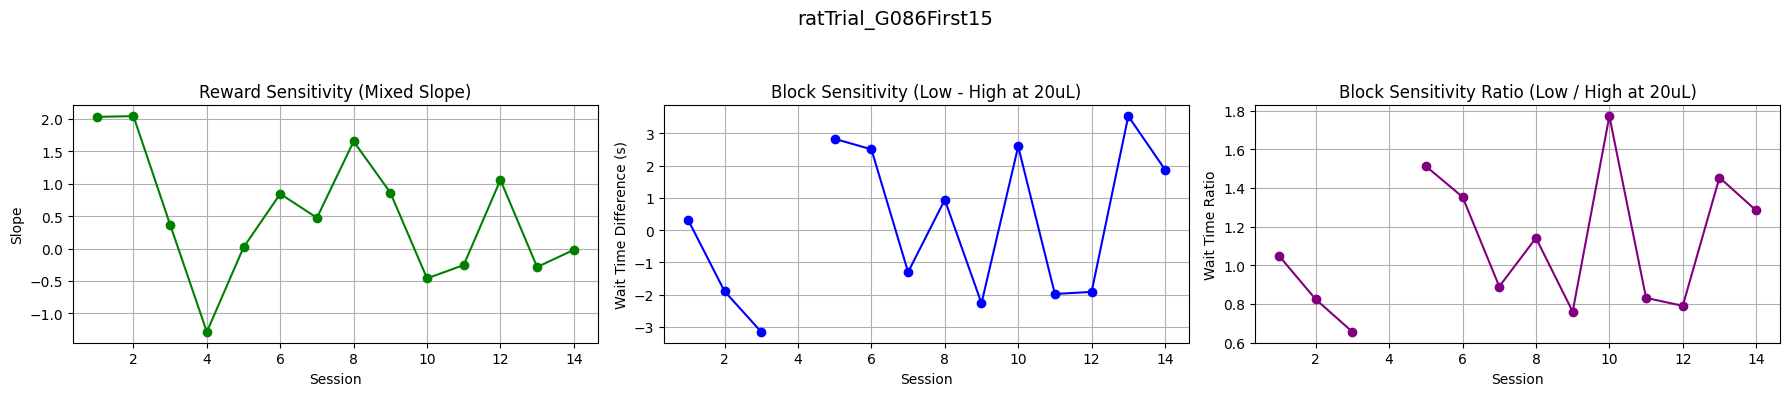

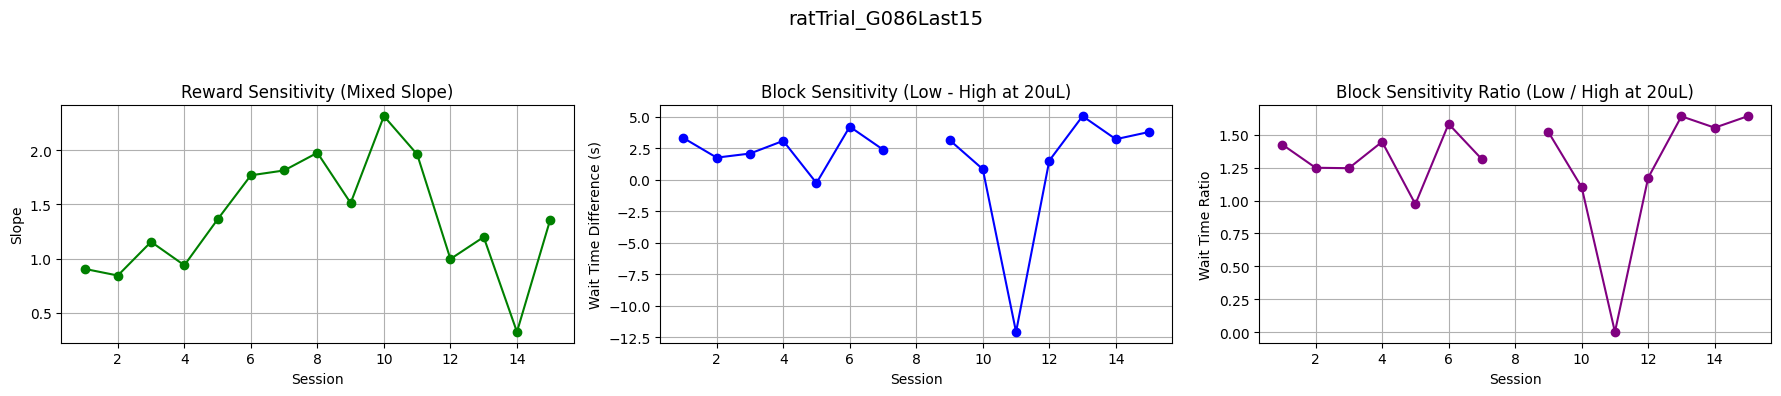

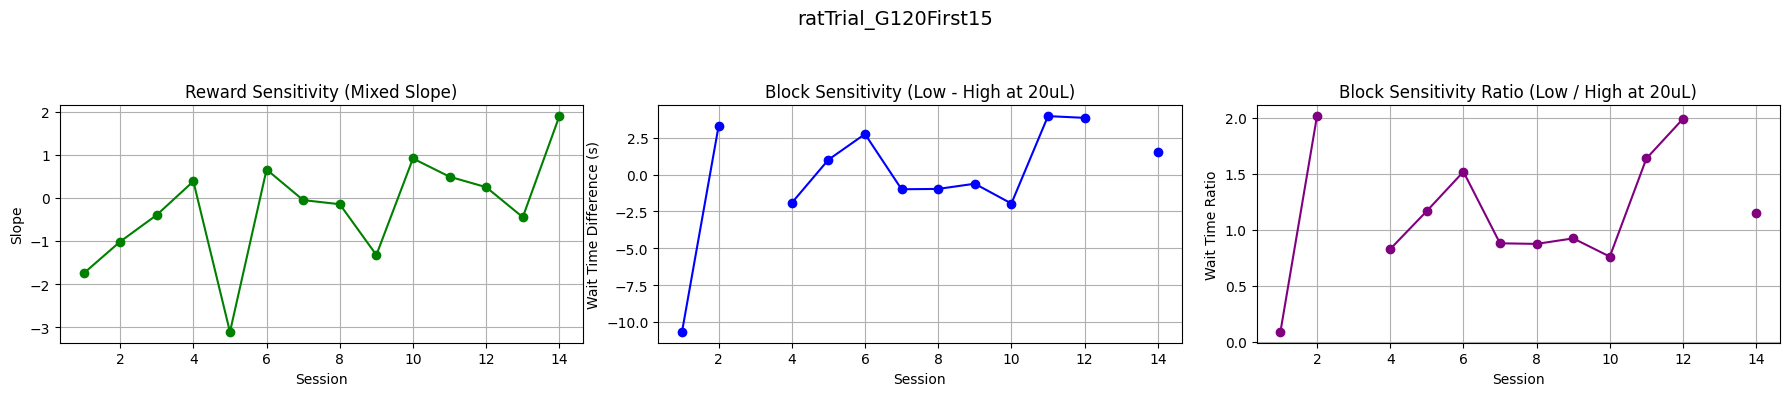

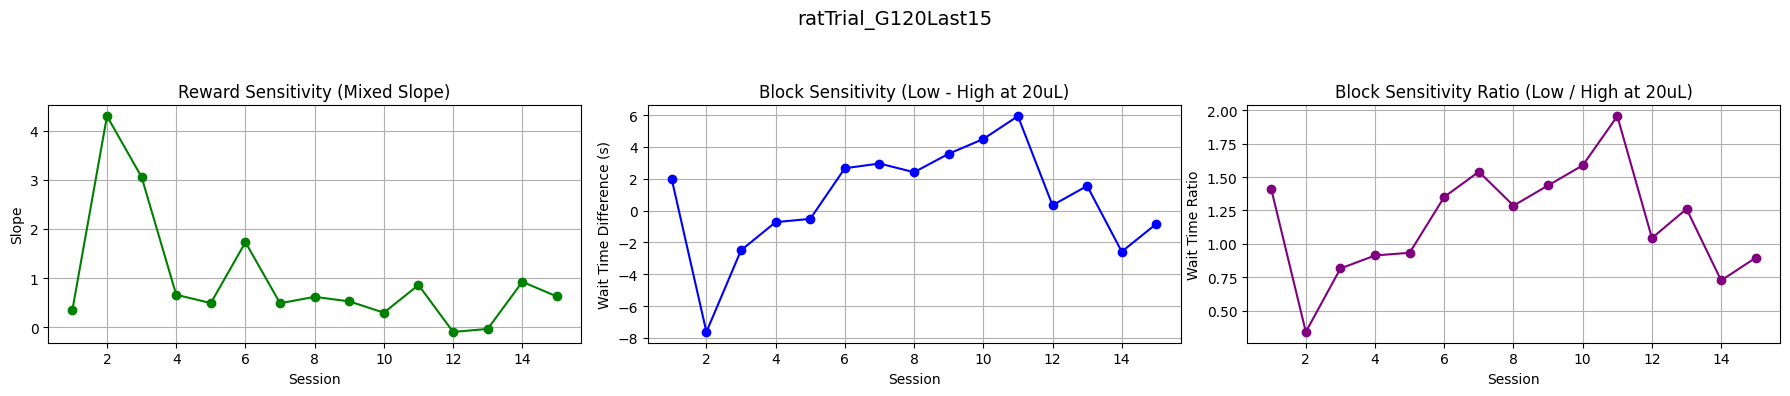

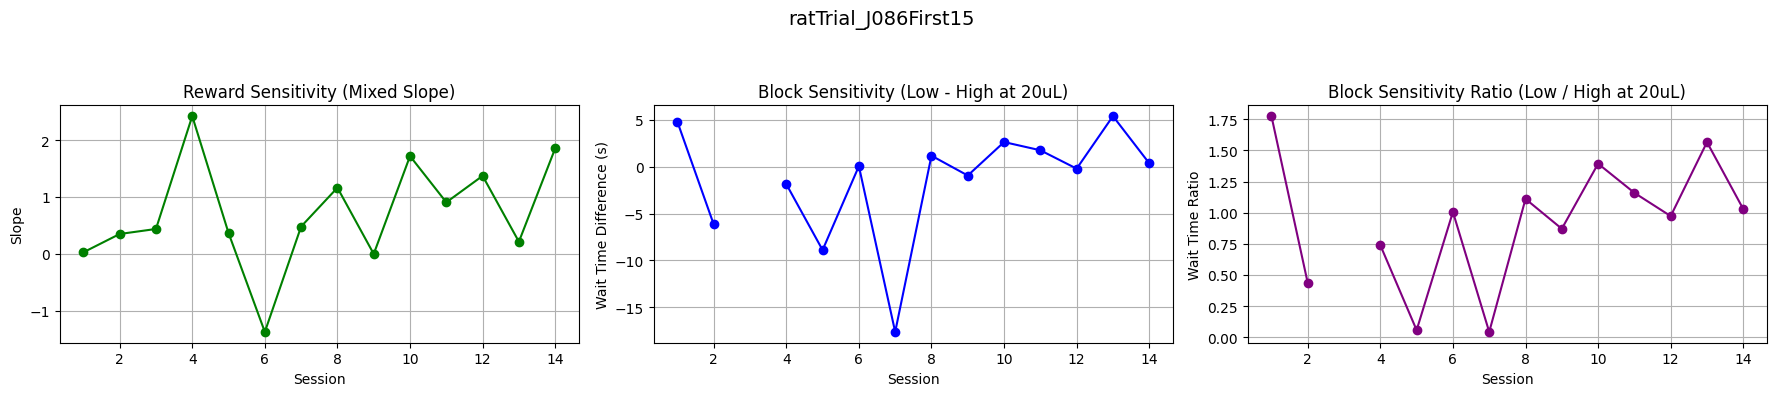

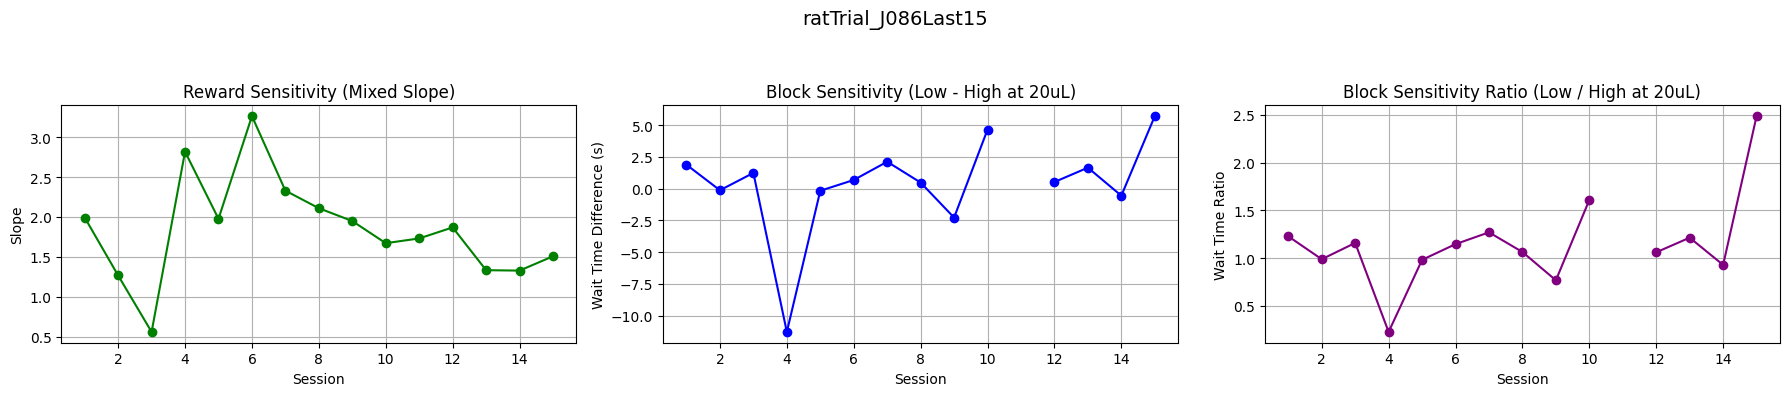

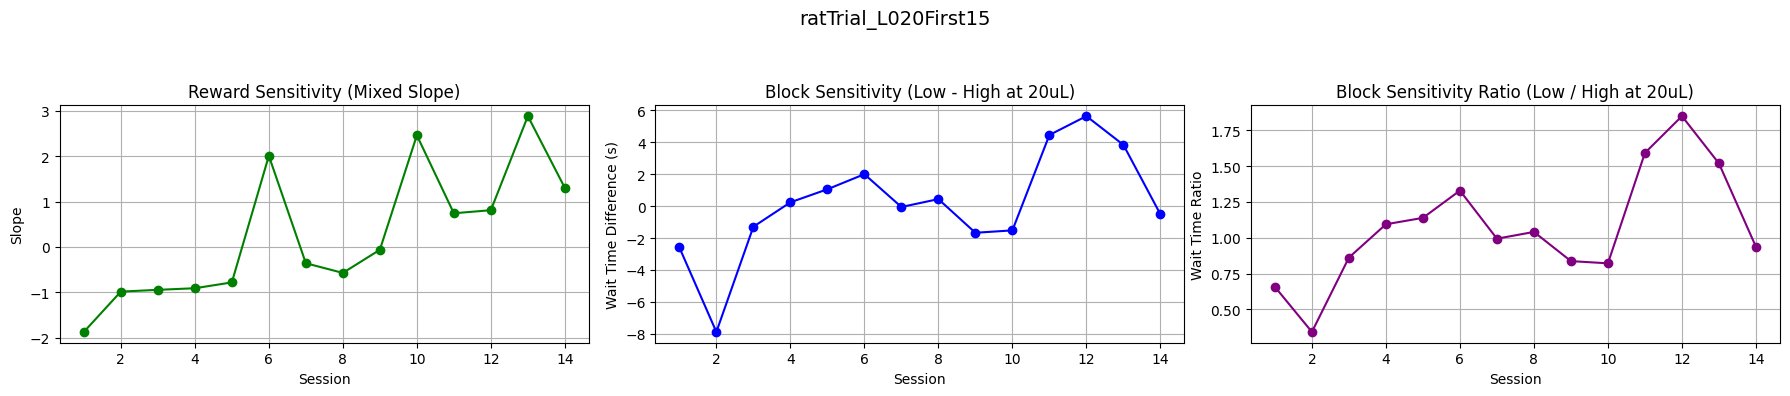

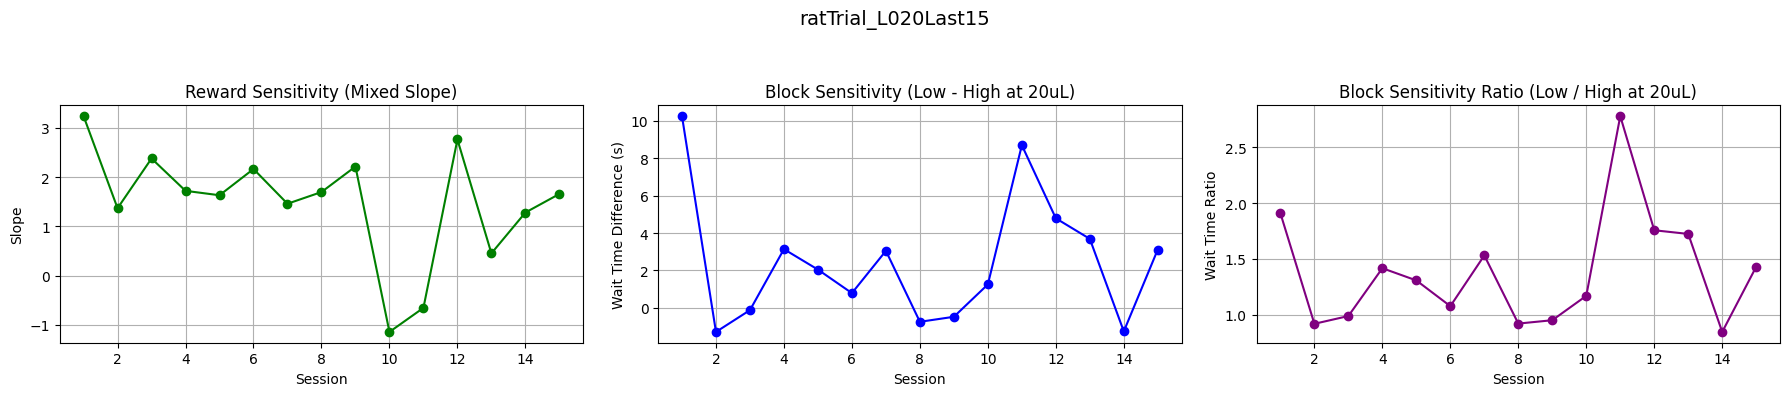

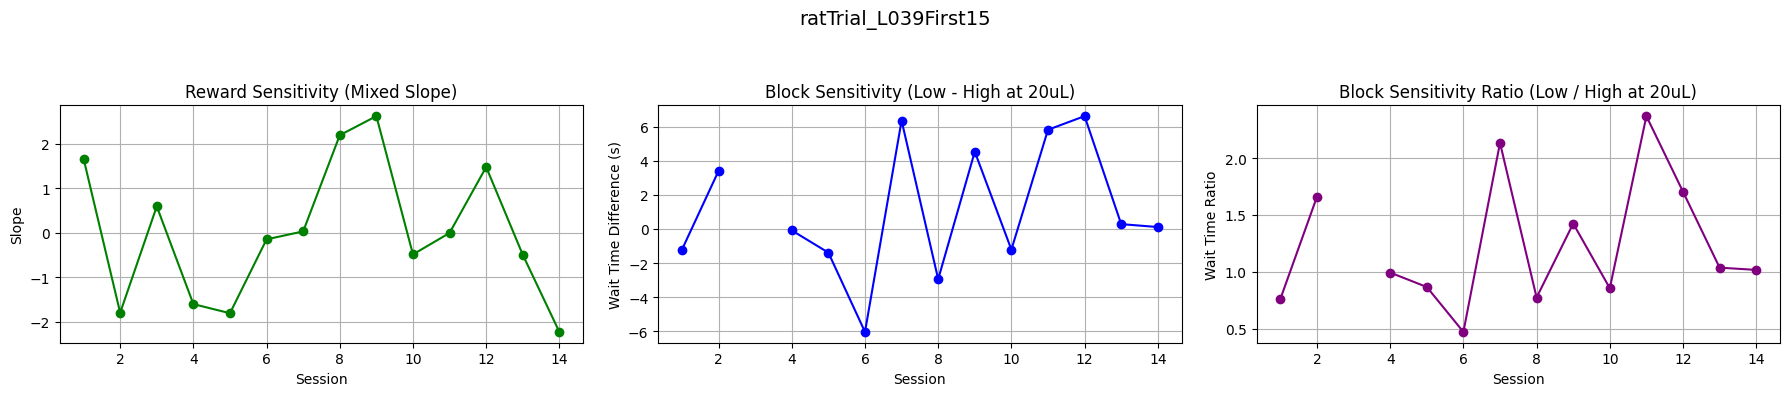

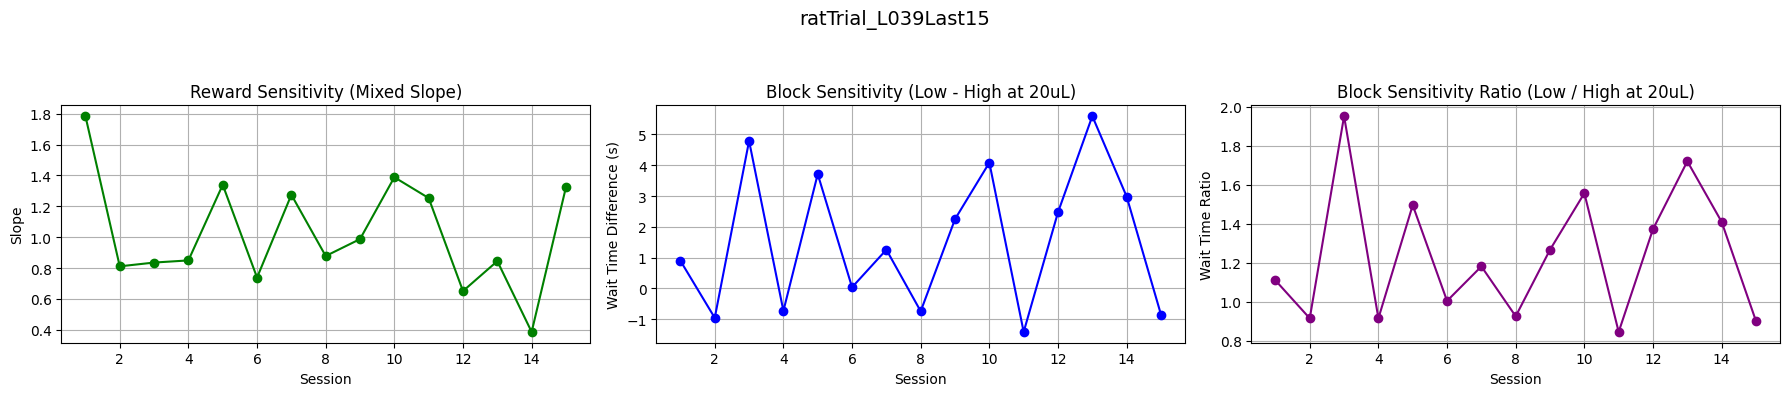

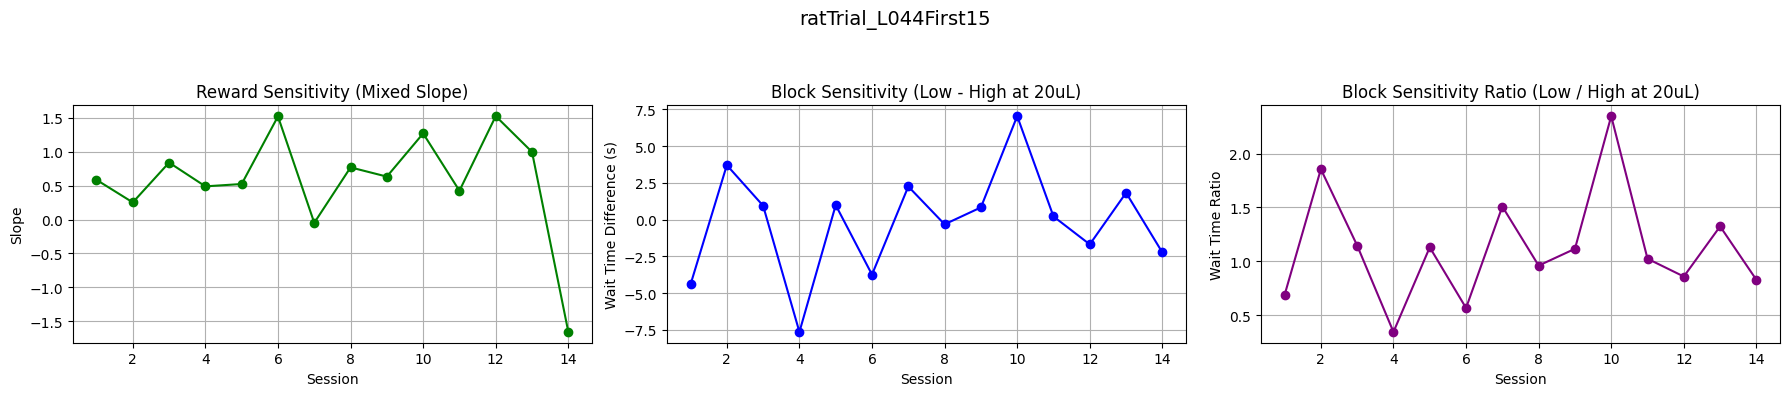

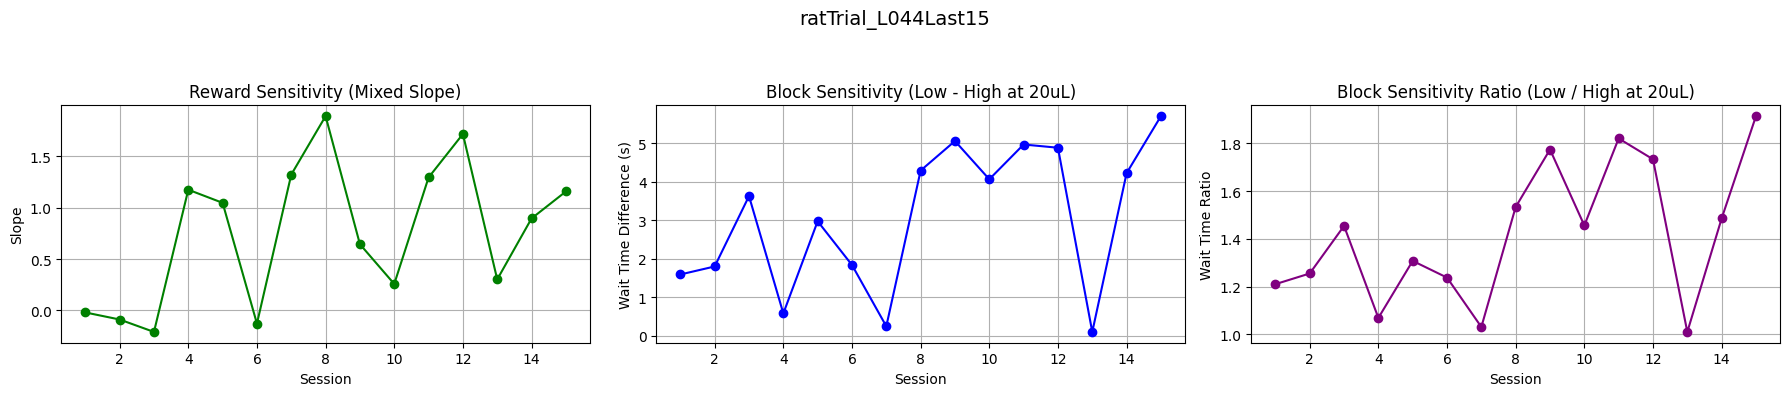

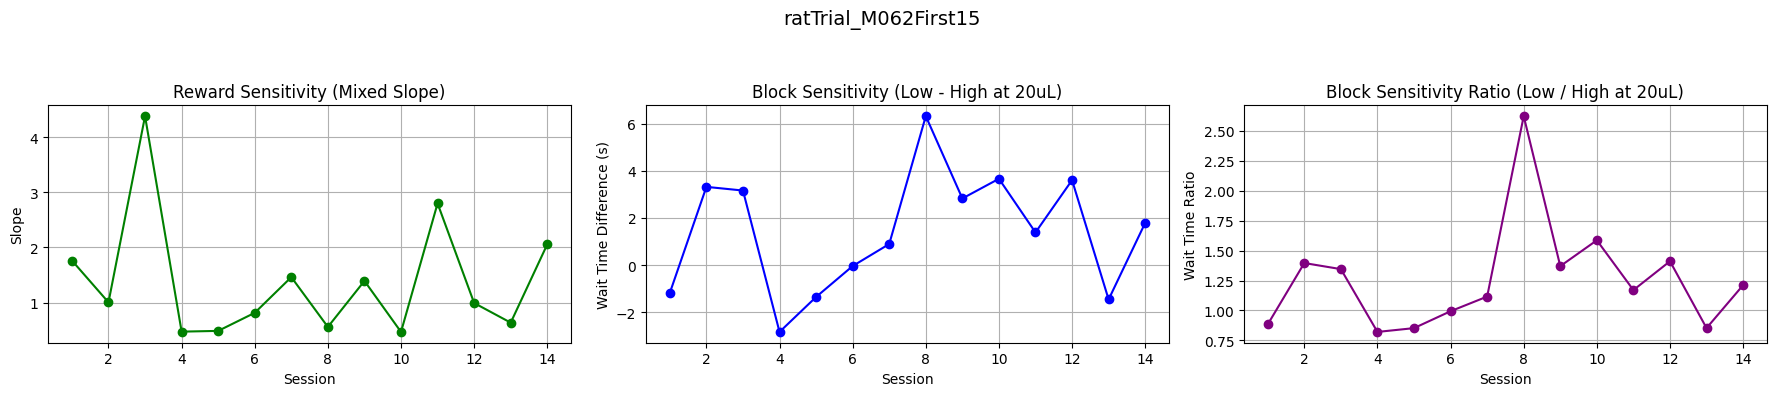

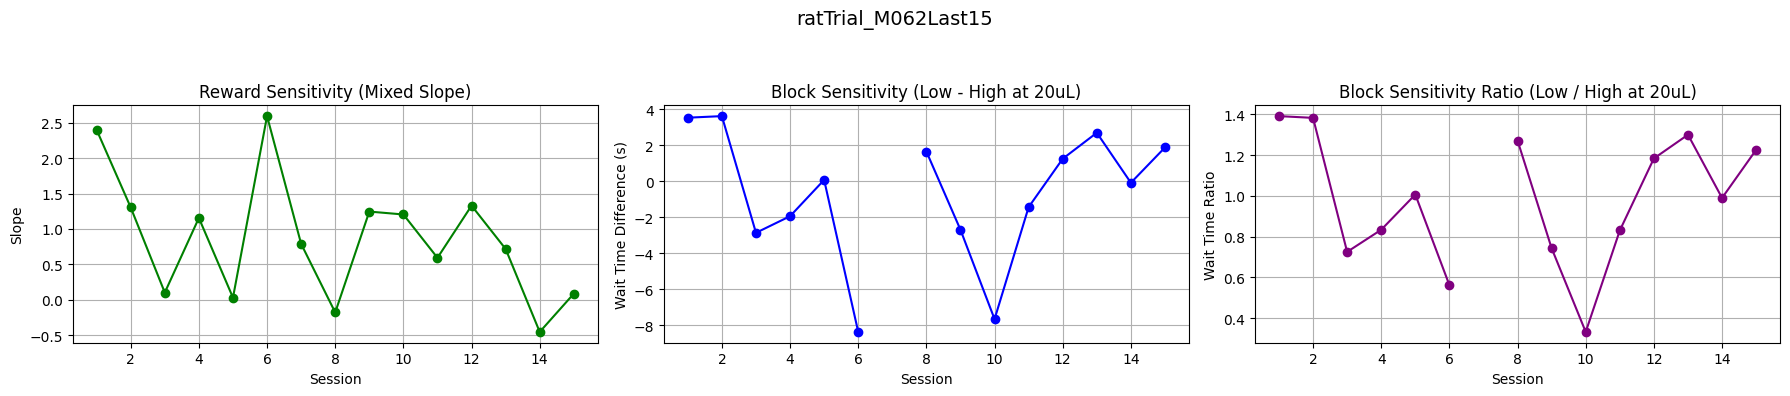

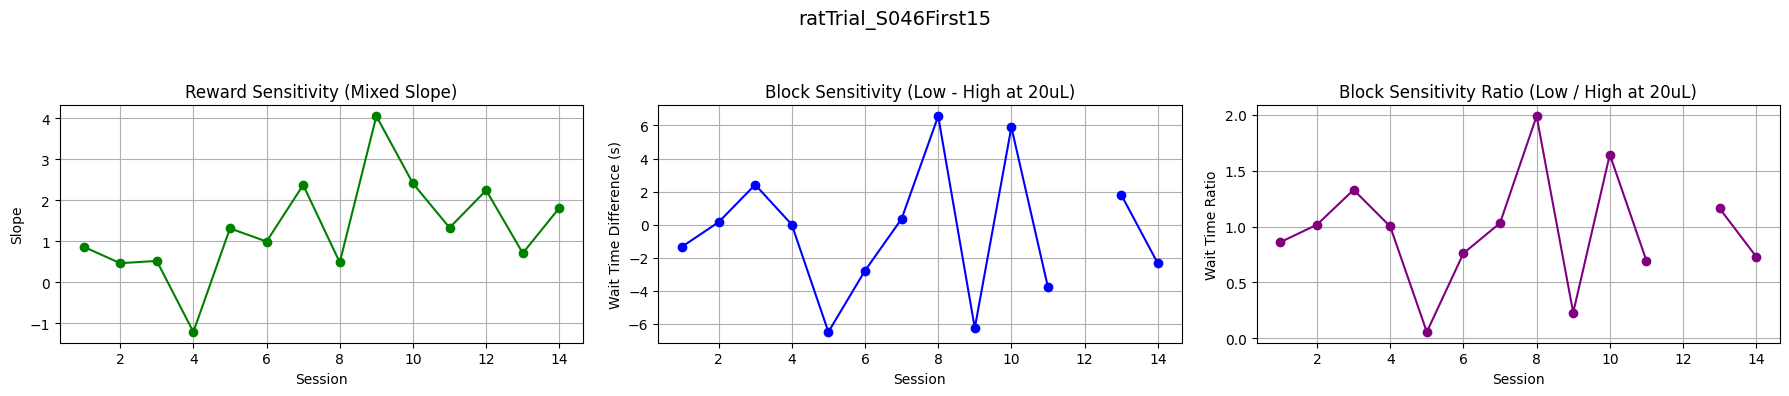

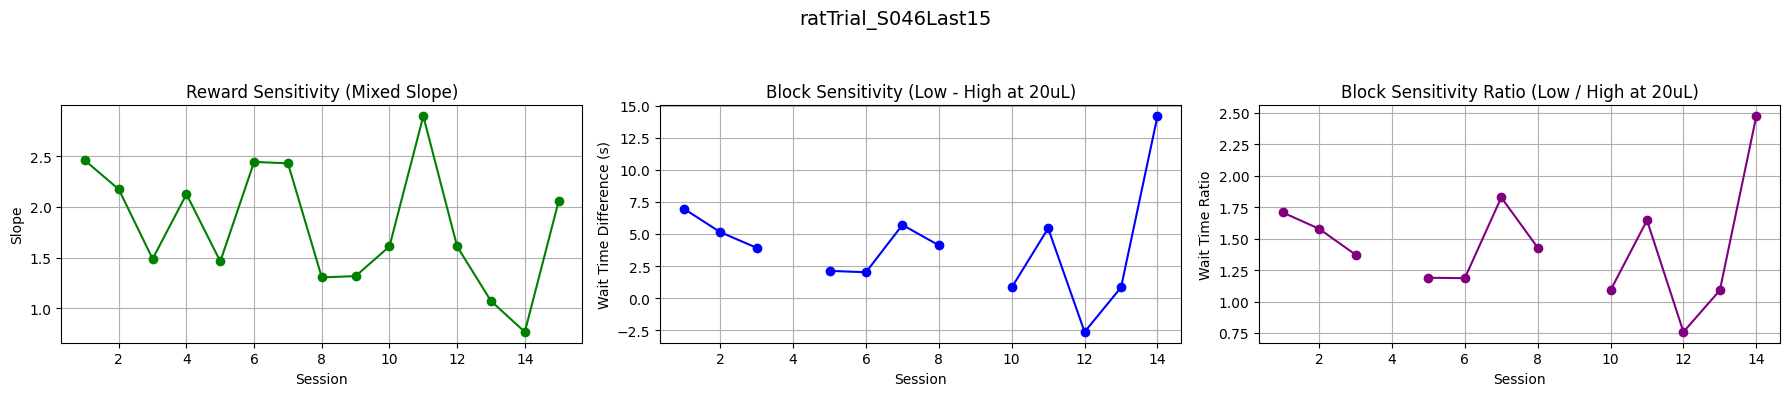

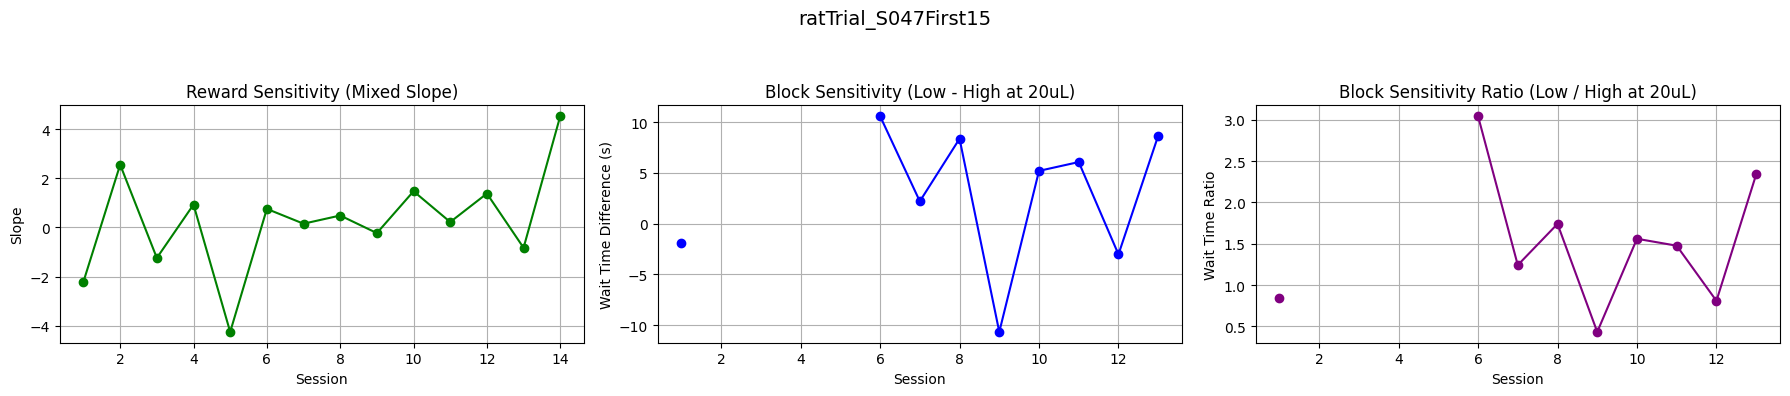

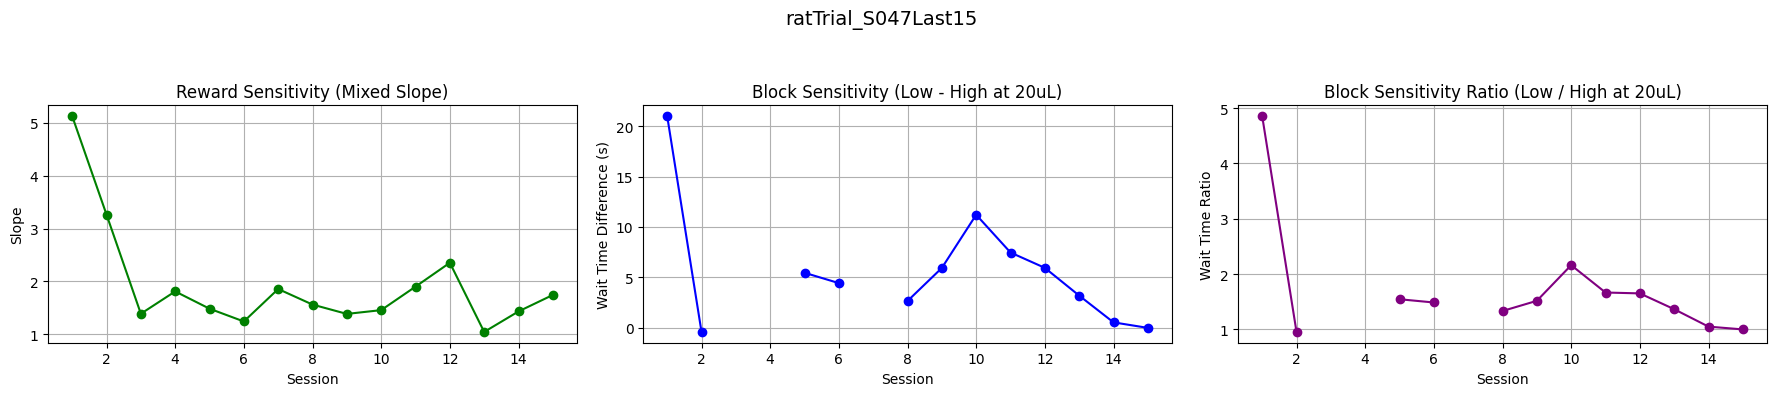

In [231]:
# plot per-session trends in block and reward sensitivity for each rat
for file in all_files:
    rat_id = file.split('/')[-1].split('.')[0]
    beh_df = load_behavior_data(file)

    # get session-wise reward sensitivity and block sensitivity (both diff and ratio)
    slope_sens = calc_mixed_slope_per_session(beh_df)
    block_sens, block_sens_ratio = calc_block_sensitivity_per_session(beh_df)

    num_sessions = beh_df['session_num'].nunique()
    sessions = np.arange(1, num_sessions + 1)

    fig, axs = plt.subplots(1, 3, figsize=(18, 4))  # now 3 plots

    # reward sensitivity plot
    axs[0].plot(sessions, slope_sens, marker='o', color='green')
    axs[0].set_title('Reward Sensitivity (Mixed Slope)')
    axs[0].set_xlabel('Session')
    axs[0].set_ylabel('Slope')
    axs[0].grid(True)

    # block sensitivity difference plot
    axs[1].plot(sessions, block_sens, marker='o', color='blue')
    axs[1].set_title('Block Sensitivity (Low - High at 20uL)')
    axs[1].set_xlabel('Session')
    axs[1].set_ylabel('Wait Time Difference (s)')
    axs[1].grid(True)

    # block sensitivity ratio plot
    axs[2].plot(sessions, block_sens_ratio, marker='o', color='purple')
    axs[2].set_title('Block Sensitivity Ratio (Low / High at 20uL)')
    axs[2].set_xlabel('Session')
    axs[2].set_ylabel('Wait Time Ratio')
    axs[2].grid(True)

    fig.suptitle(rat_id, fontsize=14)
    plt.tight_layout(rect=[0, 0, 1, 0.92])
    plt.show()